- mean_test_auc_roc using Logistic Regression:
- mean_test_auc_roc using KNN:0.631033
- mean_test_auc_roc using SVM:0.658805
- mean_test_auc_roc using Random Forest:0.657398
- mean_test_auc_roc using Decision Tree:0.640888
- mean_test_auc_roc using **Naive Bayes:0.659468**
- mean_test_auc_roc using Neural Network(Adam):0.634302
- mean_test_auc_roc using Neural Network(SGD):0.630862
- mean_test_auc_roc using Neural Network(RMSprop):0.629448

In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam,RMSprop

In [3]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

In [4]:
import tensorflow
auc_roc = tensorflow.keras.metrics.AUC(name='auc_roc',num_thresholds=20000,curve='ROC')

In [5]:
#First Model
def create_model():
    model = Sequential()
    model.add(Dense(
        32, 
        activation='swish', 
        kernel_initializer='normal',
        #kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))),
        kernel_regularizer=regularizers.l1_l2(l1=1e-6),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)))
    #model.add(Dense(32, activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='swish'))
    #model.add(Dropout(0.2))
    #model.add(Dense(128,activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer=Adam(learning_rate=0.0001,
                   beta_1=0.99,
                   beta_2=0.1,
                   epsilon=1e-06)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy',auc_roc])
    return model

In [6]:
# Wrap Keras model so it can be used by scikit-learn
kears_estimator = KerasClassifier(build_fn=create_model,epochs=100, batch_size=128, verbose=1)
#kears_estimator = KerasClassifier(build_fn=create_model,epochs=200, batch_size=512, verbose=1)
#kears_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [7]:
# vif thresholds to apply to data and labels before grid search pipeline
#vif_thresholds = [0, 5]
vif_thresholds = [0]

# we want to actually select a certain percentage of features of whatever remains
# after vif thresholding.  So we will calculate these in the loop based on the number
# of features in data, and add to the parameters dictionary before the grid search
#features__k_ratios = np.array([0.25, 0.5, 0.75, 1.0])
features__k_ratios = np.array([0.2, 0.25, 0.3, 0.35, 0.4, 0.5])

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None

# search over vif threshold meta parameters, create separate df from vif_threshold
# for otherwise identical grid searches
for vif_threshold in vif_thresholds:
    # display progress
    print('')
    print('=' * 50)
    print('Starting vif meta-parameter condition: vif_threshold: ', vif_threshold)
    
    # pipeline to apply vif threshold selection
    vif_pipeline = Pipeline(
      [
        ('vif',      VIFThresholdTransformer(score_threshold=vif_threshold)),
      ]
    )
 
    df_vif_features = vif_pipeline.transform(df_features)
    num_trials, num_features = df_vif_features.shape
    print('   Number of trials: ', num_trials, ' Number of Features: ', num_features)
    
    parameters = {
        'scaling__type_of_scaling': ['standard'],
        'outlier__outlier_threshold': [0.0, 3.0],
        'features__k': [12],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        'balance__balancer_type': ['allknn', 'smote-enn'],
        #'balance__balancer_type': ['allknn'],
        #'model__var_smoothing': [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12],
        #'model__batch_size': [8, 16, 24, 32, 40, 48],#usually multiple of 8
        #'model__epochs':[100,150,200],
        #'model__batch_size': [128],
        #'model__epochs':[10],
        #'model__optimizer' : ['RMSprop', 'Adagrad', 'Adadelta','Adam']
    }

    # set feature selection k correctly
    features__k = features__k_ratios * num_features
    features__k = features__k.astype(int) 
    parameters['features__k'] = features__k.tolist()

    # Estimator Pipeline
    pipeline = Pipeline(
      [
        ('progress', GridSearchProgressHack(verbose=False)),
        ('scaling',  FeatureScalerTransformer()),
        ('outlier',  WinsorizationOutlierTransformer()),
        ('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        ('balance',  ClassImbalanceTransformer()),
        ('model',    kears_estimator)
      ]
    )
    
    # Cross Validation Splitter
    cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
    search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc','accuracy'],
        cv = cv_group_splitter,
        refit = 'roc_auc',
        verbose = 1
    )
    search.fit(df_vif_features, mind_wandered_label, groups=participant_ids)
    
    # append results onto the dataframe collecting the results.  Need to add
    # a feature column to this dataframe for the vif vit condition here
    df = pd.DataFrame(data=search.cv_results_)
    df['param__vif_score_threshold'] = vif_threshold
    
    if best_estimator is None:
        df_result = df
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_
    else:
        df_result = df_result.append(df, ignore_index=True)
        if search.best_score_ > best_score:
            best_estimator = search.best_estimator_
            best_score = search.best_score_
            best_params = search.best_params_
            best_index = search.best_index_  # todo this is only the index of this search


Starting vif meta-parameter condition: vif_threshold:  0
   Number of trials:  4076  Number of Features:  62
Fitting 5 folds for each of 24 candidates, totalling 120 fits
0001 Epoch 1/100
14/14 [==============================] - 1s 15ms/step - loss: 0.7009 - accuracy: 0.5459 - auc_roc: 0.5766
Epoch 2/100
14/14 [==============================] - 0s 16ms/step - loss: 0.6956 - accuracy: 0.6145 - auc_roc: 0.6634
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6919 - accuracy: 0.6435 - auc_roc: 0.6950
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6871 - accuracy: 0.6857 - auc_roc: 0.7180
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6814 - accuracy: 0.6834 - auc_roc: 0.7296
Epoch 6/100
14/14 [==============================] - 0s 16ms/step - loss: 0.6781 - accuracy: 0.6811 - auc_roc: 0.7212
Epoch 7/100
14/14 [==============================] - 0s 16ms/step - loss: 0.6732 - accuracy: 0.6962 - auc_roc: 0.73

14/14 [==============================] - 0s 15ms/step - loss: 0.5785 - accuracy: 0.7107 - auc_roc: 0.7758
Epoch 69/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5883 - accuracy: 0.7141 - auc_roc: 0.7686
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5682 - accuracy: 0.7271 - auc_roc: 0.7893
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5818 - accuracy: 0.7071 - auc_roc: 0.7723
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5797 - accuracy: 0.7199 - auc_roc: 0.7741
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5763 - accuracy: 0.7129 - auc_roc: 0.7820
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5823 - accuracy: 0.7070 - auc_roc: 0.7698
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5898 - accuracy: 0.7086 - auc_roc: 0.7617
Epoch 76/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.7021 - accuracy: 0.5280 - auc_roc: 0.7153
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6980 - accuracy: 0.5861 - auc_roc: 0.6024
Epoch 3/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.6524 - auc_roc: 0.6735
Epoch 4/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6897 - accuracy: 0.6611 - auc_roc: 0.6749
Epoch 5/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6839 - accuracy: 0.6771 - auc_roc: 0.7111
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6809 - accuracy: 0.6749 - auc_roc: 0.7105
Epoch 7/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6771 - accuracy: 0.6894 - auc_roc: 0.7072
Epoch 8/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6748 - accuracy: 0.6611 - auc_roc: 0.7066
Epoch 9/100
15/15 [==============================] - 0s 

15/15 [==============================] - 0s 14ms/step - loss: 0.5829 - accuracy: 0.7174 - auc_roc: 0.7708
Epoch 70/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5709 - accuracy: 0.7303 - auc_roc: 0.7808
Epoch 71/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5966 - accuracy: 0.7004 - auc_roc: 0.7508
Epoch 72/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6001 - accuracy: 0.7093 - auc_roc: 0.7483
Epoch 73/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5909 - accuracy: 0.7016 - auc_roc: 0.7618
Epoch 74/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5987 - accuracy: 0.6912 - auc_roc: 0.7529
Epoch 75/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5793 - accuracy: 0.7215 - auc_roc: 0.7799
Epoch 76/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5755 - accuracy: 0.7171 - auc_roc: 0.7774
Epoch 77/100
15/15 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.6999 - accuracy: 0.5046 - auc_roc: 0.7191
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6947 - accuracy: 0.5914 - auc_roc: 0.6244
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6908 - accuracy: 0.6270 - auc_roc: 0.6553
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6833 - accuracy: 0.6512 - auc_roc: 0.6940
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6791 - accuracy: 0.6567 - auc_roc: 0.7140
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6748 - accuracy: 0.6830 - auc_roc: 0.7307
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6731 - accuracy: 0.6818 - auc_roc: 0.7210
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6639 - accuracy: 0.6952 - auc_roc: 0.7417
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5924 - accuracy: 0.7196 - auc_roc: 0.7645
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5891 - accuracy: 0.7149 - auc_roc: 0.7687
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6233 - accuracy: 0.6998 - auc_roc: 0.7337
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6011 - accuracy: 0.7022 - auc_roc: 0.7545
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6063 - accuracy: 0.7115 - auc_roc: 0.7522
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5898 - accuracy: 0.7128 - auc_roc: 0.7663
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5835 - accuracy: 0.7334 - auc_roc: 0.7745
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6008 - accuracy: 0.7063 - auc_roc: 0.7509
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7167 - accuracy: 0.3534 - auc_roc: 0.6840
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7090 - accuracy: 0.4015 - auc_roc: 0.3955
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7021 - accuracy: 0.4742 - auc_roc: 0.4953
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6969 - accuracy: 0.5366 - auc_roc: 0.5815
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6918 - accuracy: 0.5923 - auc_roc: 0.6327
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6867 - accuracy: 0.6148 - auc_roc: 0.6747
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6785 - accuracy: 0.6700 - auc_roc: 0.7213
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6716 - accuracy: 0.6713 - auc_roc: 0.7361
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5947 - accuracy: 0.7062 - auc_roc: 0.7587
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5910 - accuracy: 0.7167 - auc_roc: 0.7614
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5883 - accuracy: 0.7267 - auc_roc: 0.7648
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5969 - accuracy: 0.7143 - auc_roc: 0.7587
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5836 - accuracy: 0.7081 - auc_roc: 0.7706
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5898 - accuracy: 0.7174 - auc_roc: 0.7671
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5954 - accuracy: 0.7066 - auc_roc: 0.7590
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5832 - accuracy: 0.7304 - auc_roc: 0.7735
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.6980 - accuracy: 0.5459 - auc_roc: 0.7287
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.5852 - auc_roc: 0.6337
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6891 - accuracy: 0.6178 - auc_roc: 0.6639
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6852 - accuracy: 0.6211 - auc_roc: 0.6682
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6802 - accuracy: 0.6359 - auc_roc: 0.6831
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6732 - accuracy: 0.6512 - auc_roc: 0.7063
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6743 - accuracy: 0.6269 - auc_roc: 0.6800
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6645 - accuracy: 0.6643 - auc_roc: 0.7192
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5909 - accuracy: 0.7086 - auc_roc: 0.7644
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5727 - accuracy: 0.7160 - auc_roc: 0.7885
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5862 - accuracy: 0.7251 - auc_roc: 0.7741
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5952 - accuracy: 0.7064 - auc_roc: 0.7599
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5905 - accuracy: 0.7084 - auc_roc: 0.7650
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5879 - accuracy: 0.7073 - auc_roc: 0.7696
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6010 - accuracy: 0.7042 - auc_roc: 0.7585
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5887 - accuracy: 0.7072 - auc_roc: 0.7653
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 0s 640us/step
0006 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.6924 - accuracy: 0.6477 - auc_roc: 0.7435
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6873 - accuracy: 0.6853 - auc_roc: 0.7166
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6825 - accuracy: 0.7078 - auc_roc: 0.7370
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6766 - accuracy: 0.7193 - auc_roc: 0.7554
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6727 - accuracy: 0.7009 - auc_roc: 0.7419
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6667 - accuracy: 0.7294 - auc_roc: 0.7671
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6654 - accuracy: 0.7192 - auc_roc: 0.7482
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6597 - accuracy: 0.7099 - auc_roc: 0.7518
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5721 - accuracy: 0.7369 - auc_roc: 0.7830
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5716 - accuracy: 0.7225 - auc_roc: 0.7866
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5874 - accuracy: 0.7208 - auc_roc: 0.7694
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5792 - accuracy: 0.7168 - auc_roc: 0.7761
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5964 - accuracy: 0.7113 - auc_roc: 0.7653
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5793 - accuracy: 0.7123 - auc_roc: 0.7752
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5807 - accuracy: 0.7181 - auc_roc: 0.7732
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5823 - accuracy: 0.7192 - auc_roc: 0.7670
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.7036 - accuracy: 0.5059 - auc_roc: 0.7100
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6994 - accuracy: 0.5715 - auc_roc: 0.5561
Epoch 3/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6956 - accuracy: 0.6123 - auc_roc: 0.6382
Epoch 4/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6890 - accuracy: 0.6613 - auc_roc: 0.7178
Epoch 5/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6848 - accuracy: 0.6647 - auc_roc: 0.7267
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6809 - accuracy: 0.6612 - auc_roc: 0.7201
Epoch 7/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6745 - accuracy: 0.6617 - auc_roc: 0.7430
Epoch 8/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6718 - accuracy: 0.6711 - auc_roc: 0.7181
Epoch 9/100
15/15 [==============================] - 0s 

15/15 [==============================] - 0s 14ms/step - loss: 0.5885 - accuracy: 0.7135 - auc_roc: 0.7632
Epoch 70/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5938 - accuracy: 0.6989 - auc_roc: 0.7554
Epoch 71/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5948 - accuracy: 0.7065 - auc_roc: 0.7558
Epoch 72/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5890 - accuracy: 0.6898 - auc_roc: 0.7627
Epoch 73/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5920 - accuracy: 0.7003 - auc_roc: 0.7621
Epoch 74/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5942 - accuracy: 0.6973 - auc_roc: 0.7618
Epoch 75/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5864 - accuracy: 0.7049 - auc_roc: 0.7688
Epoch 76/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5939 - accuracy: 0.6940 - auc_roc: 0.7580
Epoch 77/100
15/15 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7037 - accuracy: 0.4729 - auc_roc: 0.7107
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6988 - accuracy: 0.5663 - auc_roc: 0.6049
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6940 - accuracy: 0.6373 - auc_roc: 0.6888
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6885 - accuracy: 0.6831 - auc_roc: 0.7255
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6863 - accuracy: 0.6762 - auc_roc: 0.7140
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6809 - accuracy: 0.6813 - auc_roc: 0.7331
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6776 - accuracy: 0.6877 - auc_roc: 0.7321
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6707 - accuracy: 0.7027 - auc_roc: 0.7476
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5985 - accuracy: 0.7167 - auc_roc: 0.7569
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5930 - accuracy: 0.7118 - auc_roc: 0.7638
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5852 - accuracy: 0.7214 - auc_roc: 0.7671
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5859 - accuracy: 0.7096 - auc_roc: 0.7668
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5870 - accuracy: 0.7175 - auc_roc: 0.7702
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5959 - accuracy: 0.7212 - auc_roc: 0.7592
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5823 - accuracy: 0.7144 - auc_roc: 0.7734
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5883 - accuracy: 0.7237 - auc_roc: 0.7660
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7102 - accuracy: 0.4082 - auc_roc: 0.6976
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7017 - accuracy: 0.4721 - auc_roc: 0.4863
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6967 - accuracy: 0.5476 - auc_roc: 0.5732
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6902 - accuracy: 0.6006 - auc_roc: 0.6460
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6843 - accuracy: 0.6492 - auc_roc: 0.7046
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6772 - accuracy: 0.6818 - auc_roc: 0.7342
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6719 - accuracy: 0.6909 - auc_roc: 0.7293
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6661 - accuracy: 0.7057 - auc_roc: 0.7476
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5608 - accuracy: 0.7516 - auc_roc: 0.7904
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5696 - accuracy: 0.7258 - auc_roc: 0.7832
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5739 - accuracy: 0.7348 - auc_roc: 0.7752
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5829 - accuracy: 0.7275 - auc_roc: 0.7738
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5925 - accuracy: 0.7180 - auc_roc: 0.7550
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5723 - accuracy: 0.7212 - auc_roc: 0.7779
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5824 - accuracy: 0.7318 - auc_roc: 0.7719
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5644 - accuracy: 0.7423 - auc_roc: 0.7900
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7062 - accuracy: 0.4517 - auc_roc: 0.7139
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7001 - accuracy: 0.5356 - auc_roc: 0.5808
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6960 - accuracy: 0.6063 - auc_roc: 0.6357
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6905 - accuracy: 0.6377 - auc_roc: 0.6805
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6867 - accuracy: 0.6597 - auc_roc: 0.6842
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6804 - accuracy: 0.6657 - auc_roc: 0.7178
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6773 - accuracy: 0.6671 - auc_roc: 0.7063
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6753 - accuracy: 0.6628 - auc_roc: 0.7067
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5868 - accuracy: 0.7116 - auc_roc: 0.7701
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5882 - accuracy: 0.7047 - auc_roc: 0.7709
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5812 - accuracy: 0.7244 - auc_roc: 0.7748
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5899 - accuracy: 0.7076 - auc_roc: 0.7685
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5932 - accuracy: 0.7136 - auc_roc: 0.7639
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5899 - accuracy: 0.7018 - auc_roc: 0.7632
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5725 - accuracy: 0.7451 - auc_roc: 0.7907
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5775 - accuracy: 0.7175 - auc_roc: 0.7811
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7106 - accuracy: 0.3973 - auc_roc: 0.6991
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7057 - accuracy: 0.4765 - auc_roc: 0.4740
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7014 - accuracy: 0.5583 - auc_roc: 0.5866
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6964 - accuracy: 0.6297 - auc_roc: 0.6665
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6916 - accuracy: 0.6653 - auc_roc: 0.7082
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6870 - accuracy: 0.6711 - auc_roc: 0.7232
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6831 - accuracy: 0.6871 - auc_roc: 0.7375
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6814 - accuracy: 0.6706 - auc_roc: 0.7239
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5808 - accuracy: 0.7229 - auc_roc: 0.7764
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5780 - accuracy: 0.7245 - auc_roc: 0.7791
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5798 - accuracy: 0.7429 - auc_roc: 0.7804
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5720 - accuracy: 0.7330 - auc_roc: 0.7827
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5722 - accuracy: 0.7242 - auc_roc: 0.7811
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5773 - accuracy: 0.7300 - auc_roc: 0.7813
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5874 - accuracy: 0.7186 - auc_roc: 0.7713
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5833 - accuracy: 0.7339 - auc_roc: 0.7773
Epoch 77/100
14/14 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 0s 659us/step
0012 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.6969 - accuracy: 0.6302 - auc_roc: 0.7519
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6918 - accuracy: 0.6496 - auc_roc: 0.6940
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6858 - accuracy: 0.6719 - auc_roc: 0.7143
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6801 - accuracy: 0.6680 - auc_roc: 0.7201
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6763 - accuracy: 0.6692 - auc_roc: 0.7225
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6674 - accuracy: 0.6886 - auc_roc: 0.7403
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6611 - accuracy: 0.7014 - auc_roc: 0.7551
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6616 - accuracy: 0.6785 - auc_roc: 0.7274
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5846 - accuracy: 0.7096 - auc_roc: 0.7679
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5908 - accuracy: 0.7154 - auc_roc: 0.7615
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5829 - accuracy: 0.7187 - auc_roc: 0.7708
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5889 - accuracy: 0.7194 - auc_roc: 0.7641
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5746 - accuracy: 0.7316 - auc_roc: 0.7785
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5759 - accuracy: 0.7223 - auc_roc: 0.7743
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5935 - accuracy: 0.7072 - auc_roc: 0.7615
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5907 - accuracy: 0.7085 - auc_roc: 0.7656
Epoch 77/100
14/14 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7033 - accuracy: 0.4951 - auc_roc: 0.7219
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6992 - accuracy: 0.5855 - auc_roc: 0.6056
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6940 - accuracy: 0.6356 - auc_roc: 0.6793
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6866 - accuracy: 0.6793 - auc_roc: 0.7296
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6835 - accuracy: 0.6896 - auc_roc: 0.7353
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6791 - accuracy: 0.6949 - auc_roc: 0.7449
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6743 - accuracy: 0.7266 - auc_roc: 0.7569
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6672 - accuracy: 0.7092 - auc_roc: 0.7638
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5582 - accuracy: 0.7324 - auc_roc: 0.7921
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5623 - accuracy: 0.7461 - auc_roc: 0.7895
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5531 - accuracy: 0.7293 - auc_roc: 0.7967
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5539 - accuracy: 0.7288 - auc_roc: 0.8016
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5631 - accuracy: 0.7289 - auc_roc: 0.7844
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5557 - accuracy: 0.7193 - auc_roc: 0.7906
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5598 - accuracy: 0.7346 - auc_roc: 0.7916
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5589 - accuracy: 0.7341 - auc_roc: 0.7943
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.6982 - accuracy: 0.6210 - auc_roc: 0.7575
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6943 - accuracy: 0.6531 - auc_roc: 0.7080
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6901 - accuracy: 0.6609 - auc_roc: 0.7156
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6860 - accuracy: 0.6645 - auc_roc: 0.7250
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6802 - accuracy: 0.6819 - auc_roc: 0.7389
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6765 - accuracy: 0.6738 - auc_roc: 0.7283
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6726 - accuracy: 0.6794 - auc_roc: 0.7434
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6705 - accuracy: 0.6697 - auc_roc: 0.7309
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5570 - accuracy: 0.7297 - auc_roc: 0.7865
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5614 - accuracy: 0.7260 - auc_roc: 0.7871
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5704 - accuracy: 0.7109 - auc_roc: 0.7731
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5723 - accuracy: 0.7047 - auc_roc: 0.7740
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5684 - accuracy: 0.7091 - auc_roc: 0.7730
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5693 - accuracy: 0.7068 - auc_roc: 0.7726
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5740 - accuracy: 0.7161 - auc_roc: 0.7670
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5673 - accuracy: 0.7202 - auc_roc: 0.7759
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7062 - accuracy: 0.5076 - auc_roc: 0.7192
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6992 - accuracy: 0.5705 - auc_roc: 0.5935
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6944 - accuracy: 0.6274 - auc_roc: 0.6451
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6850 - accuracy: 0.6748 - auc_roc: 0.7198
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6802 - accuracy: 0.6864 - auc_roc: 0.7380
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6784 - accuracy: 0.6747 - auc_roc: 0.7184
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6693 - accuracy: 0.6910 - auc_roc: 0.7432
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6699 - accuracy: 0.6810 - auc_roc: 0.7288
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5686 - accuracy: 0.7306 - auc_roc: 0.7919
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5752 - accuracy: 0.7154 - auc_roc: 0.7782
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5644 - accuracy: 0.7285 - auc_roc: 0.7912
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5815 - accuracy: 0.7237 - auc_roc: 0.7762
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5750 - accuracy: 0.7224 - auc_roc: 0.7851
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5641 - accuracy: 0.7318 - auc_roc: 0.7897
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5558 - accuracy: 0.7395 - auc_roc: 0.8028
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5582 - accuracy: 0.7402 - auc_roc: 0.8003
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.6971 - accuracy: 0.5973 - auc_roc: 0.7515
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6923 - accuracy: 0.6071 - auc_roc: 0.6531
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6890 - accuracy: 0.6406 - auc_roc: 0.6686
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6836 - accuracy: 0.6415 - auc_roc: 0.6902
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6753 - accuracy: 0.6791 - auc_roc: 0.7188
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6738 - accuracy: 0.6797 - auc_roc: 0.7119
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6696 - accuracy: 0.6706 - auc_roc: 0.7105
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6643 - accuracy: 0.6914 - auc_roc: 0.7241
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5741 - accuracy: 0.7241 - auc_roc: 0.7907
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5800 - accuracy: 0.7184 - auc_roc: 0.7807
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5876 - accuracy: 0.7092 - auc_roc: 0.7689
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5643 - accuracy: 0.7291 - auc_roc: 0.7969
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5710 - accuracy: 0.7313 - auc_roc: 0.7957
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5768 - accuracy: 0.7196 - auc_roc: 0.7853
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5815 - accuracy: 0.7180 - auc_roc: 0.7718
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5878 - accuracy: 0.7082 - auc_roc: 0.7688
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7034 - accuracy: 0.5201 - auc_roc: 0.7305
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6997 - accuracy: 0.5685 - auc_roc: 0.6090
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6958 - accuracy: 0.6064 - auc_roc: 0.6488
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6905 - accuracy: 0.6382 - auc_roc: 0.7046
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6860 - accuracy: 0.6724 - auc_roc: 0.7356
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6817 - accuracy: 0.6847 - auc_roc: 0.7273
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6794 - accuracy: 0.6839 - auc_roc: 0.7290
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6732 - accuracy: 0.6910 - auc_roc: 0.7386
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5859 - accuracy: 0.7153 - auc_roc: 0.7623
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5961 - accuracy: 0.7076 - auc_roc: 0.7564
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5778 - accuracy: 0.7321 - auc_roc: 0.7728
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5955 - accuracy: 0.7087 - auc_roc: 0.7638
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5792 - accuracy: 0.7160 - auc_roc: 0.7740
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5827 - accuracy: 0.7004 - auc_roc: 0.7697
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5769 - accuracy: 0.7228 - auc_roc: 0.7777
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5877 - accuracy: 0.7143 - auc_roc: 0.7657
Epoch 77/100
14/14 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 15ms/step - loss: 0.7026 - accuracy: 0.5390 - auc_roc: 0.7268
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6970 - accuracy: 0.5971 - auc_roc: 0.6508
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6916 - accuracy: 0.6382 - auc_roc: 0.6965
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6856 - accuracy: 0.6561 - auc_roc: 0.7223
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6799 - accuracy: 0.6888 - auc_roc: 0.7464
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6743 - accuracy: 0.7066 - auc_roc: 0.7694
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6652 - accuracy: 0.7124 - auc_roc: 0.7870
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6663 - accuracy: 0.6852 - auc_roc: 0.7506
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5689 - accuracy: 0.7179 - auc_roc: 0.7875
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5618 - accuracy: 0.7359 - auc_roc: 0.7974
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5581 - accuracy: 0.7527 - auc_roc: 0.8034
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5666 - accuracy: 0.7216 - auc_roc: 0.7910
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5598 - accuracy: 0.7190 - auc_roc: 0.7927
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5715 - accuracy: 0.7228 - auc_roc: 0.7865
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5563 - accuracy: 0.7329 - auc_roc: 0.7982
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5588 - accuracy: 0.7227 - auc_roc: 0.7942
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7053 - accuracy: 0.4866 - auc_roc: 0.7270
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6978 - accuracy: 0.5496 - auc_roc: 0.5816
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6906 - accuracy: 0.6100 - auc_roc: 0.6369
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6859 - accuracy: 0.6104 - auc_roc: 0.6492
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6788 - accuracy: 0.6304 - auc_roc: 0.6763
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6716 - accuracy: 0.6595 - auc_roc: 0.7085
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6685 - accuracy: 0.6537 - auc_roc: 0.7112
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6608 - accuracy: 0.6648 - auc_roc: 0.7215
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5595 - accuracy: 0.7261 - auc_roc: 0.7869
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5671 - accuracy: 0.7229 - auc_roc: 0.7821
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5430 - accuracy: 0.7371 - auc_roc: 0.8064
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5757 - accuracy: 0.7129 - auc_roc: 0.7727
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5731 - accuracy: 0.7188 - auc_roc: 0.7742
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5692 - accuracy: 0.7203 - auc_roc: 0.7722
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5629 - accuracy: 0.7176 - auc_roc: 0.7806
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5571 - accuracy: 0.7213 - auc_roc: 0.7847
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7088 - accuracy: 0.4561 - auc_roc: 0.7114
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7006 - accuracy: 0.5364 - auc_roc: 0.5516
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6939 - accuracy: 0.5949 - auc_roc: 0.6152
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6893 - accuracy: 0.6368 - auc_roc: 0.6666
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6869 - accuracy: 0.6200 - auc_roc: 0.6627
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6782 - accuracy: 0.6410 - auc_roc: 0.7047
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6751 - accuracy: 0.6532 - auc_roc: 0.7100
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6697 - accuracy: 0.6521 - auc_roc: 0.7195
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5635 - accuracy: 0.7247 - auc_roc: 0.7930
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5539 - accuracy: 0.7316 - auc_roc: 0.8039
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5762 - accuracy: 0.7235 - auc_roc: 0.7861
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5610 - accuracy: 0.7434 - auc_roc: 0.8021
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5658 - accuracy: 0.7246 - auc_roc: 0.7979
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5635 - accuracy: 0.7349 - auc_roc: 0.7927
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5619 - accuracy: 0.7296 - auc_roc: 0.7984
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5775 - accuracy: 0.7228 - auc_roc: 0.7852
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.7102 - accuracy: 0.4380 - auc_roc: 0.7190
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 0.7033 - accuracy: 0.5581 - auc_roc: 0.5580
Epoch 3/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6954 - accuracy: 0.6370 - auc_roc: 0.6759
Epoch 4/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6888 - accuracy: 0.6682 - auc_roc: 0.7066
Epoch 5/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6831 - accuracy: 0.6763 - auc_roc: 0.7146
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6755 - accuracy: 0.6865 - auc_roc: 0.7372
Epoch 7/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6693 - accuracy: 0.6888 - auc_roc: 0.7385
Epoch 8/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6672 - accuracy: 0.6903 - auc_roc: 0.7303
Epoch 9/100
15/15 [==============================] - 0s 

15/15 [==============================] - 0s 14ms/step - loss: 0.5910 - accuracy: 0.7108 - auc_roc: 0.7687
Epoch 70/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5858 - accuracy: 0.7199 - auc_roc: 0.7670
Epoch 71/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5731 - accuracy: 0.7154 - auc_roc: 0.7809
Epoch 72/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5788 - accuracy: 0.7153 - auc_roc: 0.7763
Epoch 73/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5933 - accuracy: 0.6980 - auc_roc: 0.7610
Epoch 74/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5764 - accuracy: 0.7161 - auc_roc: 0.7805
Epoch 75/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5871 - accuracy: 0.7006 - auc_roc: 0.7688
Epoch 76/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5739 - accuracy: 0.7182 - auc_roc: 0.7850
Epoch 77/100
15/15 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 15ms/step - loss: 0.6980 - accuracy: 0.6218 - auc_roc: 0.7456
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6923 - accuracy: 0.6642 - auc_roc: 0.7064
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6872 - accuracy: 0.6789 - auc_roc: 0.7210
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6797 - accuracy: 0.6729 - auc_roc: 0.7420
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6739 - accuracy: 0.6840 - auc_roc: 0.7412
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6694 - accuracy: 0.6948 - auc_roc: 0.7469
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6636 - accuracy: 0.6897 - auc_roc: 0.7414
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6578 - accuracy: 0.6934 - auc_roc: 0.7479
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5631 - accuracy: 0.7173 - auc_roc: 0.7890
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5919 - accuracy: 0.7013 - auc_roc: 0.7558
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5777 - accuracy: 0.6979 - auc_roc: 0.7708
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5713 - accuracy: 0.7228 - auc_roc: 0.7847
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5698 - accuracy: 0.7245 - auc_roc: 0.7849
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5900 - accuracy: 0.6981 - auc_roc: 0.7620
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5701 - accuracy: 0.7135 - auc_roc: 0.7798
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5565 - accuracy: 0.7338 - auc_roc: 0.7955
Epoch 77/100
14/14 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7054 - accuracy: 0.5472 - auc_roc: 0.7301
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7002 - accuracy: 0.5844 - auc_roc: 0.6222
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6937 - accuracy: 0.6514 - auc_roc: 0.6968
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6879 - accuracy: 0.6704 - auc_roc: 0.7208
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6841 - accuracy: 0.6573 - auc_roc: 0.7206
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6806 - accuracy: 0.6804 - auc_roc: 0.7306
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6703 - accuracy: 0.7017 - auc_roc: 0.7664
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6676 - accuracy: 0.6988 - auc_roc: 0.7572
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5473 - accuracy: 0.7530 - auc_roc: 0.8079
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5654 - accuracy: 0.7237 - auc_roc: 0.7920
Epoch 71/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5674 - accuracy: 0.7306 - auc_roc: 0.7904
Epoch 72/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5537 - accuracy: 0.7516 - auc_roc: 0.8024
Epoch 73/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5625 - accuracy: 0.7343 - auc_roc: 0.7962
Epoch 74/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5550 - accuracy: 0.7461 - auc_roc: 0.7993
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5488 - accuracy: 0.7545 - auc_roc: 0.8110
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5594 - accuracy: 0.7433 - auc_roc: 0.7946
Epoch 77/100
14/14 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.6983 - accuracy: 0.5867 - auc_roc: 0.7567
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6899 - accuracy: 0.6597 - auc_roc: 0.7177
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6833 - accuracy: 0.6782 - auc_roc: 0.7330
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6749 - accuracy: 0.6922 - auc_roc: 0.7641
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6721 - accuracy: 0.6751 - auc_roc: 0.7436
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6639 - accuracy: 0.7022 - auc_roc: 0.7634
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6577 - accuracy: 0.7066 - auc_roc: 0.7627
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6541 - accuracy: 0.6855 - auc_roc: 0.7457
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5436 - accuracy: 0.7366 - auc_roc: 0.7956
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5692 - accuracy: 0.7175 - auc_roc: 0.7732
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5387 - accuracy: 0.7383 - auc_roc: 0.8046
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5460 - accuracy: 0.7499 - auc_roc: 0.8025
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5450 - accuracy: 0.7410 - auc_roc: 0.7981
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5577 - accuracy: 0.7187 - auc_roc: 0.7881
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5500 - accuracy: 0.7352 - auc_roc: 0.7917
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5500 - accuracy: 0.7302 - auc_roc: 0.7941
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 15ms/step - loss: 0.7068 - accuracy: 0.5096 - auc_roc: 0.7302
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7001 - accuracy: 0.5584 - auc_roc: 0.5820
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6930 - accuracy: 0.6137 - auc_roc: 0.6456
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6886 - accuracy: 0.6301 - auc_roc: 0.6714
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6842 - accuracy: 0.6665 - auc_roc: 0.6946
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6754 - accuracy: 0.6684 - auc_roc: 0.7171
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6727 - accuracy: 0.6660 - auc_roc: 0.7172
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6648 - accuracy: 0.6805 - auc_roc: 0.7399
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5730 - accuracy: 0.7226 - auc_roc: 0.7865
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5927 - accuracy: 0.7155 - auc_roc: 0.7618
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5727 - accuracy: 0.7138 - auc_roc: 0.7803
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5815 - accuracy: 0.7081 - auc_roc: 0.7738
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5755 - accuracy: 0.7101 - auc_roc: 0.7759
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5754 - accuracy: 0.7129 - auc_roc: 0.7784
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5695 - accuracy: 0.7266 - auc_roc: 0.7875
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5699 - accuracy: 0.7225 - auc_roc: 0.7852
Epoch 77/100
14/14 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 15ms/step - loss: 0.7210 - accuracy: 0.3859 - auc_roc: 0.6971
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7146 - accuracy: 0.4469 - auc_roc: 0.4090
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7058 - accuracy: 0.5134 - auc_roc: 0.5235
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6980 - accuracy: 0.5869 - auc_roc: 0.6230
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6890 - accuracy: 0.6643 - auc_roc: 0.7144
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6835 - accuracy: 0.6766 - auc_roc: 0.7322
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6743 - accuracy: 0.7000 - auc_roc: 0.7542
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6730 - accuracy: 0.6767 - auc_roc: 0.7249
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5812 - accuracy: 0.7310 - auc_roc: 0.7745
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5822 - accuracy: 0.7112 - auc_roc: 0.7756
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5809 - accuracy: 0.7212 - auc_roc: 0.7741
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5966 - accuracy: 0.7097 - auc_roc: 0.7587
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5814 - accuracy: 0.7181 - auc_roc: 0.7803
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5818 - accuracy: 0.7197 - auc_roc: 0.7711
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5826 - accuracy: 0.7146 - auc_roc: 0.7748
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5862 - accuracy: 0.7056 - auc_roc: 0.7692
Epoch 77/100
14/14 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7092 - accuracy: 0.5027 - auc_roc: 0.7199
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7029 - accuracy: 0.5675 - auc_roc: 0.5774
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6959 - accuracy: 0.6241 - auc_roc: 0.6513
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6911 - accuracy: 0.6329 - auc_roc: 0.6774
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6856 - accuracy: 0.6614 - auc_roc: 0.6976
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6797 - accuracy: 0.6625 - auc_roc: 0.7142
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6705 - accuracy: 0.6815 - auc_roc: 0.7338
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6656 - accuracy: 0.6781 - auc_roc: 0.7304
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5941 - accuracy: 0.6996 - auc_roc: 0.7614
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5891 - accuracy: 0.7091 - auc_roc: 0.7653
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5711 - accuracy: 0.7111 - auc_roc: 0.7829
Epoch 72/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5851 - accuracy: 0.7110 - auc_roc: 0.7672
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5769 - accuracy: 0.7006 - auc_roc: 0.7757
Epoch 74/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5681 - accuracy: 0.7170 - auc_roc: 0.7819
Epoch 75/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5744 - accuracy: 0.7108 - auc_roc: 0.7816
Epoch 76/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5927 - accuracy: 0.7094 - auc_roc: 0.7585
Epoch 77/100
14/14 [==============================] - 0s 16ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 15ms/step - loss: 0.7084 - accuracy: 0.4450 - auc_roc: 0.7083
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7028 - accuracy: 0.5261 - auc_roc: 0.5408
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6983 - accuracy: 0.5688 - auc_roc: 0.6102
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6910 - accuracy: 0.6488 - auc_roc: 0.6862
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6858 - accuracy: 0.6689 - auc_roc: 0.7157
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6794 - accuracy: 0.6711 - auc_roc: 0.7245
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6732 - accuracy: 0.6945 - auc_roc: 0.7467
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6696 - accuracy: 0.6860 - auc_roc: 0.7389
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5621 - accuracy: 0.7345 - auc_roc: 0.7951
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5724 - accuracy: 0.7217 - auc_roc: 0.7809
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5685 - accuracy: 0.7117 - auc_roc: 0.7835
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5621 - accuracy: 0.7346 - auc_roc: 0.7980
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5724 - accuracy: 0.7196 - auc_roc: 0.7836
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5660 - accuracy: 0.7189 - auc_roc: 0.7872
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5456 - accuracy: 0.7273 - auc_roc: 0.8051
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5653 - accuracy: 0.7190 - auc_roc: 0.7880
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7122 - accuracy: 0.4746 - auc_roc: 0.7251
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7033 - accuracy: 0.5339 - auc_roc: 0.5748
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6945 - accuracy: 0.5990 - auc_roc: 0.6480
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6854 - accuracy: 0.6526 - auc_roc: 0.6992
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6768 - accuracy: 0.6544 - auc_roc: 0.7190
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6689 - accuracy: 0.6747 - auc_roc: 0.7396
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6574 - accuracy: 0.7003 - auc_roc: 0.7628
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6539 - accuracy: 0.6976 - auc_roc: 0.7443
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5552 - accuracy: 0.7310 - auc_roc: 0.7900
Epoch 70/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5421 - accuracy: 0.7384 - auc_roc: 0.8031
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5346 - accuracy: 0.7356 - auc_roc: 0.8083
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5550 - accuracy: 0.7283 - auc_roc: 0.7848
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5404 - accuracy: 0.7461 - auc_roc: 0.7995
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5370 - accuracy: 0.7445 - auc_roc: 0.8086
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5520 - accuracy: 0.7375 - auc_roc: 0.7864
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5346 - accuracy: 0.7397 - auc_roc: 0.8090
Epoch 77/100
14/14 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7066 - accuracy: 0.5506 - auc_roc: 0.7424
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7002 - accuracy: 0.5827 - auc_roc: 0.6177
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6965 - accuracy: 0.6275 - auc_roc: 0.6541
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6901 - accuracy: 0.6695 - auc_roc: 0.6896
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6850 - accuracy: 0.6828 - auc_roc: 0.7260
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6783 - accuracy: 0.6732 - auc_roc: 0.7300
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6752 - accuracy: 0.6812 - auc_roc: 0.7238
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6687 - accuracy: 0.6852 - auc_roc: 0.7395
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5889 - accuracy: 0.7105 - auc_roc: 0.7674
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5829 - accuracy: 0.7115 - auc_roc: 0.7738
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5875 - accuracy: 0.7064 - auc_roc: 0.7694
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5994 - accuracy: 0.7083 - auc_roc: 0.7596
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5750 - accuracy: 0.7277 - auc_roc: 0.7802
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5717 - accuracy: 0.7293 - auc_roc: 0.7866
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5858 - accuracy: 0.7161 - auc_roc: 0.7731
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6019 - accuracy: 0.7030 - auc_roc: 0.7614
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7164 - accuracy: 0.4791 - auc_roc: 0.7180
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7067 - accuracy: 0.5334 - auc_roc: 0.5635
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7000 - accuracy: 0.5949 - auc_roc: 0.6352
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6936 - accuracy: 0.6463 - auc_roc: 0.6873
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6895 - accuracy: 0.6679 - auc_roc: 0.7082
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6839 - accuracy: 0.6717 - auc_roc: 0.7242
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6783 - accuracy: 0.6701 - auc_roc: 0.7274
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6741 - accuracy: 0.6769 - auc_roc: 0.7299
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5561 - accuracy: 0.7279 - auc_roc: 0.8046
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5817 - accuracy: 0.7127 - auc_roc: 0.7748
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5733 - accuracy: 0.7316 - auc_roc: 0.7854
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5727 - accuracy: 0.7131 - auc_roc: 0.7801
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5719 - accuracy: 0.7214 - auc_roc: 0.7833
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5760 - accuracy: 0.7247 - auc_roc: 0.7838
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5700 - accuracy: 0.7190 - auc_roc: 0.7882
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5737 - accuracy: 0.7124 - auc_roc: 0.7827
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7206 - accuracy: 0.4116 - auc_roc: 0.7093
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7125 - accuracy: 0.5165 - auc_roc: 0.4912
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7078 - accuracy: 0.5560 - auc_roc: 0.5512
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7014 - accuracy: 0.6142 - auc_roc: 0.6494
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6949 - accuracy: 0.6401 - auc_roc: 0.7008
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6886 - accuracy: 0.6676 - auc_roc: 0.7221
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6852 - accuracy: 0.6719 - auc_roc: 0.7196
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6788 - accuracy: 0.6906 - auc_roc: 0.7433
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5688 - accuracy: 0.7208 - auc_roc: 0.7862
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5783 - accuracy: 0.7072 - auc_roc: 0.7774
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5799 - accuracy: 0.6964 - auc_roc: 0.7704
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5765 - accuracy: 0.7091 - auc_roc: 0.7771
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5842 - accuracy: 0.6897 - auc_roc: 0.7674
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5844 - accuracy: 0.7105 - auc_roc: 0.7725
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5693 - accuracy: 0.7315 - auc_roc: 0.7852
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5681 - accuracy: 0.7108 - auc_roc: 0.7895
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7137 - accuracy: 0.5001 - auc_roc: 0.7164
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7071 - accuracy: 0.5555 - auc_roc: 0.5689
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6993 - accuracy: 0.6128 - auc_roc: 0.6536
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6918 - accuracy: 0.6556 - auc_roc: 0.7058
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6850 - accuracy: 0.6932 - auc_roc: 0.7482
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6802 - accuracy: 0.6848 - auc_roc: 0.7381
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6738 - accuracy: 0.6955 - auc_roc: 0.7562
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6697 - accuracy: 0.6899 - auc_roc: 0.7499
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5680 - accuracy: 0.7367 - auc_roc: 0.7900
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5721 - accuracy: 0.7226 - auc_roc: 0.7858
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5679 - accuracy: 0.7401 - auc_roc: 0.7886
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5637 - accuracy: 0.7432 - auc_roc: 0.7908
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5548 - accuracy: 0.7448 - auc_roc: 0.8025
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5498 - accuracy: 0.7451 - auc_roc: 0.8038
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5745 - accuracy: 0.7308 - auc_roc: 0.7835
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5485 - accuracy: 0.7374 - auc_roc: 0.8041
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7088 - accuracy: 0.5322 - auc_roc: 0.7405
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6997 - accuracy: 0.6247 - auc_roc: 0.6769
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6937 - accuracy: 0.6477 - auc_roc: 0.7096
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6865 - accuracy: 0.6934 - auc_roc: 0.7421
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6804 - accuracy: 0.6748 - auc_roc: 0.7471
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6721 - accuracy: 0.7052 - auc_roc: 0.7672
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6687 - accuracy: 0.6920 - auc_roc: 0.7589
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6594 - accuracy: 0.7022 - auc_roc: 0.7717
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5602 - accuracy: 0.7192 - auc_roc: 0.7841
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5426 - accuracy: 0.7493 - auc_roc: 0.8015
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5568 - accuracy: 0.7293 - auc_roc: 0.7940
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5581 - accuracy: 0.7224 - auc_roc: 0.7856
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5508 - accuracy: 0.7361 - auc_roc: 0.7955
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5436 - accuracy: 0.7371 - auc_roc: 0.7984
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5467 - accuracy: 0.7390 - auc_roc: 0.7989
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5431 - accuracy: 0.7406 - auc_roc: 0.7939
Epoch 77/100
14/14 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7049 - accuracy: 0.5707 - auc_roc: 0.7448
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6969 - accuracy: 0.6404 - auc_roc: 0.6787
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6913 - accuracy: 0.6500 - auc_roc: 0.7052
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6851 - accuracy: 0.6832 - auc_roc: 0.7352
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6782 - accuracy: 0.6895 - auc_roc: 0.7370
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6727 - accuracy: 0.6747 - auc_roc: 0.7370
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6628 - accuracy: 0.7149 - auc_roc: 0.7705
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6656 - accuracy: 0.6748 - auc_roc: 0.7260
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5627 - accuracy: 0.7259 - auc_roc: 0.7891
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5583 - accuracy: 0.7258 - auc_roc: 0.7962
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5617 - accuracy: 0.7363 - auc_roc: 0.7940
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5687 - accuracy: 0.7189 - auc_roc: 0.7867
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5682 - accuracy: 0.7260 - auc_roc: 0.7884
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5666 - accuracy: 0.7233 - auc_roc: 0.7868
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5646 - accuracy: 0.7125 - auc_roc: 0.7894
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5627 - accuracy: 0.7312 - auc_roc: 0.7919
Epoch 77/100
14/14 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7158 - accuracy: 0.4661 - auc_roc: 0.7215
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7089 - accuracy: 0.5320 - auc_roc: 0.5267
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7042 - accuracy: 0.5703 - auc_roc: 0.5695
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6971 - accuracy: 0.6027 - auc_roc: 0.6366
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6912 - accuracy: 0.6531 - auc_roc: 0.6762
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6845 - accuracy: 0.6511 - auc_roc: 0.6911
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6789 - accuracy: 0.6607 - auc_roc: 0.7062
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6743 - accuracy: 0.6819 - auc_roc: 0.7151
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5744 - accuracy: 0.7154 - auc_roc: 0.7771
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5813 - accuracy: 0.7167 - auc_roc: 0.7737
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5782 - accuracy: 0.7178 - auc_roc: 0.7751
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5772 - accuracy: 0.7196 - auc_roc: 0.7796
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5729 - accuracy: 0.7202 - auc_roc: 0.7848
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5776 - accuracy: 0.7228 - auc_roc: 0.7759
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5565 - accuracy: 0.7444 - auc_roc: 0.7993
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5715 - accuracy: 0.7220 - auc_roc: 0.7852
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.7157 - accuracy: 0.4140 - auc_roc: 0.6978
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 0.7077 - accuracy: 0.5295 - auc_roc: 0.5387
Epoch 3/100
15/15 [==============================] - 0s 14ms/step - loss: 0.7024 - accuracy: 0.6192 - auc_roc: 0.6389
Epoch 4/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6961 - accuracy: 0.6286 - auc_roc: 0.7000
Epoch 5/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6903 - accuracy: 0.6555 - auc_roc: 0.7208
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6842 - accuracy: 0.6586 - auc_roc: 0.7390
Epoch 7/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6814 - accuracy: 0.6658 - auc_roc: 0.7206
Epoch 8/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6757 - accuracy: 0.6656 - auc_roc: 0.7363
Epoch 9/100
15/15 [==============================] - 0s 

15/15 [==============================] - 0s 16ms/step - loss: 0.5996 - accuracy: 0.6863 - auc_roc: 0.7490
Epoch 70/100
15/15 [==============================] - 0s 15ms/step - loss: 0.5920 - accuracy: 0.6869 - auc_roc: 0.7557
Epoch 71/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5874 - accuracy: 0.7016 - auc_roc: 0.7631
Epoch 72/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5976 - accuracy: 0.6833 - auc_roc: 0.7508
Epoch 73/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5926 - accuracy: 0.6872 - auc_roc: 0.7544
Epoch 74/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5844 - accuracy: 0.7011 - auc_roc: 0.7671
Epoch 75/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5889 - accuracy: 0.6933 - auc_roc: 0.7589
Epoch 76/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5987 - accuracy: 0.7019 - auc_roc: 0.7521
Epoch 77/100
15/15 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7061 - accuracy: 0.5444 - auc_roc: 0.7177
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7001 - accuracy: 0.6010 - auc_roc: 0.6404
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6926 - accuracy: 0.6450 - auc_roc: 0.7024
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6850 - accuracy: 0.6884 - auc_roc: 0.7400
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6785 - accuracy: 0.6963 - auc_roc: 0.7494
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6730 - accuracy: 0.6893 - auc_roc: 0.7474
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6705 - accuracy: 0.6887 - auc_roc: 0.7406
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6626 - accuracy: 0.7036 - auc_roc: 0.7579
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5813 - accuracy: 0.7172 - auc_roc: 0.7713
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5859 - accuracy: 0.7103 - auc_roc: 0.7677
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5827 - accuracy: 0.7283 - auc_roc: 0.7739
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5721 - accuracy: 0.7122 - auc_roc: 0.7803
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5742 - accuracy: 0.7229 - auc_roc: 0.7836
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5752 - accuracy: 0.7298 - auc_roc: 0.7828
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5764 - accuracy: 0.7149 - auc_roc: 0.7796
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5765 - accuracy: 0.7114 - auc_roc: 0.7773
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 15ms/step - loss: 0.7128 - accuracy: 0.4788 - auc_roc: 0.7144
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7063 - accuracy: 0.5407 - auc_roc: 0.5731
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7025 - accuracy: 0.5972 - auc_roc: 0.6349
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6957 - accuracy: 0.6237 - auc_roc: 0.6852
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6883 - accuracy: 0.6720 - auc_roc: 0.7245
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6850 - accuracy: 0.6625 - auc_roc: 0.7247
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6793 - accuracy: 0.6934 - auc_roc: 0.7385
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6717 - accuracy: 0.6895 - auc_roc: 0.7600
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5389 - accuracy: 0.7286 - auc_roc: 0.7962
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5646 - accuracy: 0.7016 - auc_roc: 0.7721
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5419 - accuracy: 0.7244 - auc_roc: 0.7943
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5437 - accuracy: 0.7289 - auc_roc: 0.7911
Epoch 73/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5539 - accuracy: 0.7213 - auc_roc: 0.7834
Epoch 74/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5533 - accuracy: 0.7171 - auc_roc: 0.7909
Epoch 75/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5526 - accuracy: 0.7130 - auc_roc: 0.7900
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5572 - accuracy: 0.7231 - auc_roc: 0.7836
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7063 - accuracy: 0.5431 - auc_roc: 0.7366
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7010 - accuracy: 0.5986 - auc_roc: 0.6086
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6951 - accuracy: 0.6137 - auc_roc: 0.6550
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6913 - accuracy: 0.6358 - auc_roc: 0.6672
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6880 - accuracy: 0.6437 - auc_roc: 0.6756
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6825 - accuracy: 0.6757 - auc_roc: 0.7037
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6761 - accuracy: 0.6712 - auc_roc: 0.7141
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6747 - accuracy: 0.6702 - auc_roc: 0.7079
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5702 - accuracy: 0.7188 - auc_roc: 0.7872
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5846 - accuracy: 0.7081 - auc_roc: 0.7740
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5810 - accuracy: 0.7232 - auc_roc: 0.7817
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5776 - accuracy: 0.7216 - auc_roc: 0.7822
Epoch 73/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5674 - accuracy: 0.7301 - auc_roc: 0.7912
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5704 - accuracy: 0.7305 - auc_roc: 0.7887
Epoch 75/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5783 - accuracy: 0.7219 - auc_roc: 0.7796
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5860 - accuracy: 0.7138 - auc_roc: 0.7710
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 15ms/step - loss: 0.7093 - accuracy: 0.5391 - auc_roc: 0.7337
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7025 - accuracy: 0.5983 - auc_roc: 0.6210
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6917 - accuracy: 0.6432 - auc_roc: 0.6841
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6847 - accuracy: 0.6480 - auc_roc: 0.7000
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6804 - accuracy: 0.6507 - auc_roc: 0.7170
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6709 - accuracy: 0.7008 - auc_roc: 0.7536
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6673 - accuracy: 0.6907 - auc_roc: 0.7484
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6628 - accuracy: 0.6917 - auc_roc: 0.7514
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5824 - accuracy: 0.7063 - auc_roc: 0.7761
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5686 - accuracy: 0.7211 - auc_roc: 0.7859
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5587 - accuracy: 0.7341 - auc_roc: 0.7965
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5587 - accuracy: 0.7279 - auc_roc: 0.7943
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5594 - accuracy: 0.7258 - auc_roc: 0.7908
Epoch 74/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5690 - accuracy: 0.7206 - auc_roc: 0.7826
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5512 - accuracy: 0.7328 - auc_roc: 0.8008
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5607 - accuracy: 0.7297 - auc_roc: 0.7917
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.7119 - accuracy: 0.5153 - auc_roc: 0.7260
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 0.7046 - accuracy: 0.5580 - auc_roc: 0.5775
Epoch 3/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6946 - accuracy: 0.6401 - auc_roc: 0.6563
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6845 - accuracy: 0.6822 - auc_roc: 0.7068
Epoch 5/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6781 - accuracy: 0.6671 - auc_roc: 0.7184
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6747 - accuracy: 0.6762 - auc_roc: 0.7119
Epoch 7/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6657 - accuracy: 0.6825 - auc_roc: 0.7305
Epoch 8/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6602 - accuracy: 0.6712 - auc_roc: 0.7323
Epoch 9/100
15/15 [==============================] - 0s 

15/15 [==============================] - 0s 14ms/step - loss: 0.5873 - accuracy: 0.7053 - auc_roc: 0.7595
Epoch 70/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5888 - accuracy: 0.6966 - auc_roc: 0.7576
Epoch 71/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5756 - accuracy: 0.7154 - auc_roc: 0.7741
Epoch 72/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5918 - accuracy: 0.7087 - auc_roc: 0.7584
Epoch 73/100
15/15 [==============================] - 0s 15ms/step - loss: 0.5888 - accuracy: 0.7120 - auc_roc: 0.7586
Epoch 74/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5821 - accuracy: 0.7020 - auc_roc: 0.7654
Epoch 75/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6032 - accuracy: 0.6731 - auc_roc: 0.7405
Epoch 76/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5872 - accuracy: 0.7018 - auc_roc: 0.7591
Epoch 77/100
15/15 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7180 - accuracy: 0.4403 - auc_roc: 0.7060
Epoch 2/100
14/14 [==============================] - 0s 13ms/step - loss: 0.7102 - accuracy: 0.5468 - auc_roc: 0.5496
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7026 - accuracy: 0.6140 - auc_roc: 0.6550
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6950 - accuracy: 0.6652 - auc_roc: 0.7114
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6892 - accuracy: 0.6955 - auc_roc: 0.7496
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6832 - accuracy: 0.6892 - auc_roc: 0.7398
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6748 - accuracy: 0.7006 - auc_roc: 0.7635
Epoch 8/100
14/14 [==============================] - 0s 13ms/step - loss: 0.6724 - accuracy: 0.7167 - auc_roc: 0.7632
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5722 - accuracy: 0.7221 - auc_roc: 0.7854
Epoch 70/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5734 - accuracy: 0.7204 - auc_roc: 0.7829
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5692 - accuracy: 0.7197 - auc_roc: 0.7841
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5598 - accuracy: 0.7250 - auc_roc: 0.7905
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5556 - accuracy: 0.7301 - auc_roc: 0.7940
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5672 - accuracy: 0.7315 - auc_roc: 0.7869
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5387 - accuracy: 0.7462 - auc_roc: 0.8127
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5501 - accuracy: 0.7414 - auc_roc: 0.8060
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7007 - accuracy: 0.6349 - auc_roc: 0.7547
Epoch 2/100
14/14 [==============================] - 0s 13ms/step - loss: 0.6941 - accuracy: 0.6463 - auc_roc: 0.7018
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6889 - accuracy: 0.6447 - auc_roc: 0.6994
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6825 - accuracy: 0.6653 - auc_roc: 0.7259
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6746 - accuracy: 0.6760 - auc_roc: 0.7392
Epoch 6/100
14/14 [==============================] - 0s 13ms/step - loss: 0.6705 - accuracy: 0.6638 - auc_roc: 0.7225
Epoch 7/100
14/14 [==============================] - 0s 13ms/step - loss: 0.6668 - accuracy: 0.6857 - auc_roc: 0.7296
Epoch 8/100
14/14 [==============================] - 0s 13ms/step - loss: 0.6578 - accuracy: 0.6800 - auc_roc: 0.7439
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 13ms/step - loss: 0.5487 - accuracy: 0.7394 - auc_roc: 0.7917
Epoch 70/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5665 - accuracy: 0.7165 - auc_roc: 0.7765
Epoch 71/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5557 - accuracy: 0.7204 - auc_roc: 0.7829
Epoch 72/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5577 - accuracy: 0.7225 - auc_roc: 0.7759
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5608 - accuracy: 0.7247 - auc_roc: 0.7763
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5386 - accuracy: 0.7416 - auc_roc: 0.8031
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5592 - accuracy: 0.7196 - auc_roc: 0.7789
Epoch 76/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5457 - accuracy: 0.7390 - auc_roc: 0.7914
Epoch 77/100
14/14 [==============================] - 0s 13ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
15/15 [==============================] - 1s 13ms/step - loss: 0.7024 - accuracy: 0.6589 - auc_roc: 0.7554
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6955 - accuracy: 0.6581 - auc_roc: 0.7172
Epoch 3/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6883 - accuracy: 0.6813 - auc_roc: 0.7397
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6855 - accuracy: 0.6717 - auc_roc: 0.7228
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6768 - accuracy: 0.6790 - auc_roc: 0.7403
Epoch 6/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6715 - accuracy: 0.6898 - auc_roc: 0.7492
Epoch 7/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6636 - accuracy: 0.6981 - auc_roc: 0.7545
Epoch 8/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6617 - accuracy: 0.6917 - auc_roc: 0.7409
Epoch 9/100
15/15 [==============================] - 0s 

15/15 [==============================] - 0s 13ms/step - loss: 0.5845 - accuracy: 0.7075 - auc_roc: 0.7705
Epoch 70/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5726 - accuracy: 0.7151 - auc_roc: 0.7815
Epoch 71/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5783 - accuracy: 0.7180 - auc_roc: 0.7726
Epoch 72/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5781 - accuracy: 0.7167 - auc_roc: 0.7791
Epoch 73/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5813 - accuracy: 0.6983 - auc_roc: 0.7656
Epoch 74/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5761 - accuracy: 0.7157 - auc_roc: 0.7792
Epoch 75/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5745 - accuracy: 0.7154 - auc_roc: 0.7789
Epoch 76/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5808 - accuracy: 0.7210 - auc_roc: 0.7765
Epoch 77/100
15/15 [==============================] - 0s 13ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.7175 - accuracy: 0.4762 - auc_roc: 0.7113
Epoch 2/100
15/15 [==============================] - 0s 13ms/step - loss: 0.7137 - accuracy: 0.5168 - auc_roc: 0.5168
Epoch 3/100
15/15 [==============================] - 0s 13ms/step - loss: 0.7059 - accuracy: 0.5967 - auc_roc: 0.6262
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6997 - accuracy: 0.6441 - auc_roc: 0.6896
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6946 - accuracy: 0.6654 - auc_roc: 0.7109
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6869 - accuracy: 0.6944 - auc_roc: 0.7435
Epoch 7/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6830 - accuracy: 0.6835 - auc_roc: 0.7447
Epoch 8/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6794 - accuracy: 0.6819 - auc_roc: 0.7352
Epoch 9/100
15/15 [==============================] - 0s 

15/15 [==============================] - 0s 13ms/step - loss: 0.5858 - accuracy: 0.7165 - auc_roc: 0.7750
Epoch 70/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5876 - accuracy: 0.7252 - auc_roc: 0.7737
Epoch 71/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5648 - accuracy: 0.7363 - auc_roc: 0.7912
Epoch 72/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5653 - accuracy: 0.7344 - auc_roc: 0.7922
Epoch 73/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5816 - accuracy: 0.7233 - auc_roc: 0.7761
Epoch 74/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5614 - accuracy: 0.7374 - auc_roc: 0.7955
Epoch 75/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5744 - accuracy: 0.7249 - auc_roc: 0.7863
Epoch 76/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5845 - accuracy: 0.7286 - auc_roc: 0.7805
Epoch 77/100
15/15 [==============================] - 0s 13ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.7203 - accuracy: 0.4483 - auc_roc: 0.7131
Epoch 2/100
15/15 [==============================] - 0s 13ms/step - loss: 0.7131 - accuracy: 0.5021 - auc_roc: 0.5068
Epoch 3/100
15/15 [==============================] - 0s 14ms/step - loss: 0.7088 - accuracy: 0.5428 - auc_roc: 0.5453
Epoch 4/100
15/15 [==============================] - 0s 14ms/step - loss: 0.7015 - accuracy: 0.5896 - auc_roc: 0.6067
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6969 - accuracy: 0.6095 - auc_roc: 0.6490
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6921 - accuracy: 0.6349 - auc_roc: 0.6679
Epoch 7/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6885 - accuracy: 0.6434 - auc_roc: 0.6893
Epoch 8/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6837 - accuracy: 0.6431 - auc_roc: 0.6925
Epoch 9/100
15/15 [==============================] - 0s 

15/15 [==============================] - 0s 14ms/step - loss: 0.5985 - accuracy: 0.6935 - auc_roc: 0.7488
Epoch 70/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5858 - accuracy: 0.6909 - auc_roc: 0.7573
Epoch 71/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5956 - accuracy: 0.6857 - auc_roc: 0.7523
Epoch 72/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5912 - accuracy: 0.6885 - auc_roc: 0.7587
Epoch 73/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5850 - accuracy: 0.6906 - auc_roc: 0.7604
Epoch 74/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5861 - accuracy: 0.7038 - auc_roc: 0.7653
Epoch 75/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5805 - accuracy: 0.7030 - auc_roc: 0.7704
Epoch 76/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5751 - accuracy: 0.7033 - auc_roc: 0.7719
Epoch 77/100
15/15 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 13ms/step - loss: 0.7085 - accuracy: 0.5509 - auc_roc: 0.7137
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7014 - accuracy: 0.6163 - auc_roc: 0.6707
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6954 - accuracy: 0.6606 - auc_roc: 0.7168
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6901 - accuracy: 0.6745 - auc_roc: 0.7209
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6827 - accuracy: 0.6937 - auc_roc: 0.7432
Epoch 6/100
14/14 [==============================] - 0s 13ms/step - loss: 0.6758 - accuracy: 0.7099 - auc_roc: 0.7564
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6693 - accuracy: 0.7038 - auc_roc: 0.7600
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6658 - accuracy: 0.6965 - auc_roc: 0.7568
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5482 - accuracy: 0.7281 - auc_roc: 0.7988
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5587 - accuracy: 0.7206 - auc_roc: 0.7869
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5556 - accuracy: 0.7306 - auc_roc: 0.7943
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5462 - accuracy: 0.7215 - auc_roc: 0.8011
Epoch 73/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5660 - accuracy: 0.7109 - auc_roc: 0.7805
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5445 - accuracy: 0.7349 - auc_roc: 0.8071
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5656 - accuracy: 0.7221 - auc_roc: 0.7842
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5573 - accuracy: 0.7280 - auc_roc: 0.7868
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 16ms/step - loss: 0.7110 - accuracy: 0.5088 - auc_roc: 0.7326
Epoch 2/100
14/14 [==============================] - 0s 16ms/step - loss: 0.6999 - accuracy: 0.6142 - auc_roc: 0.6593
Epoch 3/100
14/14 [==============================] - 0s 16ms/step - loss: 0.6958 - accuracy: 0.6194 - auc_roc: 0.6636
Epoch 4/100
14/14 [==============================] - 0s 16ms/step - loss: 0.6850 - accuracy: 0.6744 - auc_roc: 0.7312
Epoch 5/100
14/14 [==============================] - 0s 16ms/step - loss: 0.6784 - accuracy: 0.6653 - auc_roc: 0.7291
Epoch 6/100
14/14 [==============================] - 0s 16ms/step - loss: 0.6754 - accuracy: 0.6584 - auc_roc: 0.7214
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6653 - accuracy: 0.6771 - auc_roc: 0.7484
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6572 - accuracy: 0.6810 - auc_roc: 0.7536
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 17ms/step - loss: 0.5483 - accuracy: 0.7207 - auc_roc: 0.7906
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5412 - accuracy: 0.7252 - auc_roc: 0.8027
Epoch 71/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5677 - accuracy: 0.7190 - auc_roc: 0.7740
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5580 - accuracy: 0.7195 - auc_roc: 0.7880
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5365 - accuracy: 0.7409 - auc_roc: 0.8051
Epoch 74/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5399 - accuracy: 0.7338 - auc_roc: 0.7968
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5299 - accuracy: 0.7345 - auc_roc: 0.8161
Epoch 76/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5420 - accuracy: 0.7414 - auc_roc: 0.8018
Epoch 77/100
14/14 [==============================] - 0s 13ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.7011 - accuracy: 0.6347 - auc_roc: 0.7579
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6924 - accuracy: 0.6647 - auc_roc: 0.7301
Epoch 3/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6874 - accuracy: 0.6666 - auc_roc: 0.7306
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6842 - accuracy: 0.6729 - auc_roc: 0.7257
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6758 - accuracy: 0.6922 - auc_roc: 0.7490
Epoch 6/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6742 - accuracy: 0.6709 - auc_roc: 0.7286
Epoch 7/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6604 - accuracy: 0.6963 - auc_roc: 0.7567
Epoch 8/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6610 - accuracy: 0.6931 - auc_roc: 0.7388
Epoch 9/100
15/15 [==============================] - 0s 

15/15 [==============================] - 0s 14ms/step - loss: 0.5904 - accuracy: 0.7111 - auc_roc: 0.7667
Epoch 70/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5774 - accuracy: 0.7219 - auc_roc: 0.7780
Epoch 71/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5833 - accuracy: 0.7132 - auc_roc: 0.7699
Epoch 72/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5817 - accuracy: 0.7182 - auc_roc: 0.7751
Epoch 73/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5889 - accuracy: 0.7042 - auc_roc: 0.7672
Epoch 74/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5715 - accuracy: 0.7243 - auc_roc: 0.7859
Epoch 75/100
15/15 [==============================] - 0s 13ms/step - loss: 0.5804 - accuracy: 0.7016 - auc_roc: 0.7724
Epoch 76/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5711 - accuracy: 0.7299 - auc_roc: 0.7860
Epoch 77/100
15/15 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.7188 - accuracy: 0.4854 - auc_roc: 0.7126
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 0.7120 - accuracy: 0.5359 - auc_roc: 0.5439
Epoch 3/100
15/15 [==============================] - 0s 15ms/step - loss: 0.7049 - accuracy: 0.5667 - auc_roc: 0.5967
Epoch 4/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6942 - accuracy: 0.6374 - auc_roc: 0.6789
Epoch 5/100
15/15 [==============================] - 0s 15ms/step - loss: 0.6875 - accuracy: 0.6728 - auc_roc: 0.7010
Epoch 6/100
15/15 [==============================] - 0s 17ms/step - loss: 0.6772 - accuracy: 0.6862 - auc_roc: 0.7331
Epoch 7/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6729 - accuracy: 0.6787 - auc_roc: 0.7287
Epoch 8/100
15/15 [==============================] - 0s 16ms/step - loss: 0.6658 - accuracy: 0.6898 - auc_roc: 0.7368
Epoch 9/100
15/15 [==============================] - 0s 

15/15 [==============================] - 0s 14ms/step - loss: 0.5677 - accuracy: 0.7248 - auc_roc: 0.7863
Epoch 70/100
15/15 [==============================] - 0s 16ms/step - loss: 0.5680 - accuracy: 0.7158 - auc_roc: 0.7833
Epoch 71/100
15/15 [==============================] - 0s 16ms/step - loss: 0.5958 - accuracy: 0.6937 - auc_roc: 0.7500
Epoch 72/100
15/15 [==============================] - 0s 15ms/step - loss: 0.5733 - accuracy: 0.7221 - auc_roc: 0.7806
Epoch 73/100
15/15 [==============================] - 0s 15ms/step - loss: 0.5707 - accuracy: 0.7311 - auc_roc: 0.7834
Epoch 74/100
15/15 [==============================] - 0s 17ms/step - loss: 0.5697 - accuracy: 0.7189 - auc_roc: 0.7855
Epoch 75/100
15/15 [==============================] - 0s 16ms/step - loss: 0.5706 - accuracy: 0.7139 - auc_roc: 0.7758
Epoch 76/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5807 - accuracy: 0.7052 - auc_roc: 0.7681
Epoch 77/100
15/15 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 17ms/step - loss: 0.7096 - accuracy: 0.5626 - auc_roc: 0.7409
Epoch 2/100
14/14 [==============================] - 0s 16ms/step - loss: 0.7037 - accuracy: 0.5980 - auc_roc: 0.6338
Epoch 3/100
14/14 [==============================] - 0s 18ms/step - loss: 0.6939 - accuracy: 0.6424 - auc_roc: 0.7070
Epoch 4/100
14/14 [==============================] - 0s 18ms/step - loss: 0.6868 - accuracy: 0.6744 - auc_roc: 0.7219
Epoch 5/100
14/14 [==============================] - 0s 17ms/step - loss: 0.6794 - accuracy: 0.6908 - auc_roc: 0.7387
Epoch 6/100
14/14 [==============================] - 0s 17ms/step - loss: 0.6758 - accuracy: 0.6745 - auc_roc: 0.7299
Epoch 7/100
14/14 [==============================] - 0s 17ms/step - loss: 0.6717 - accuracy: 0.6611 - auc_roc: 0.7288
Epoch 8/100
14/14 [==============================] - 0s 17ms/step - loss: 0.6613 - accuracy: 0.6882 - auc_roc: 0.7411
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5674 - accuracy: 0.7066 - auc_roc: 0.7827
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5715 - accuracy: 0.7048 - auc_roc: 0.7720
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5708 - accuracy: 0.7146 - auc_roc: 0.7733
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5709 - accuracy: 0.7136 - auc_roc: 0.7819
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5743 - accuracy: 0.7076 - auc_roc: 0.7742
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5724 - accuracy: 0.7156 - auc_roc: 0.7704
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5715 - accuracy: 0.7115 - auc_roc: 0.7773
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5582 - accuracy: 0.7182 - auc_roc: 0.7898
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7171 - accuracy: 0.5185 - auc_roc: 0.7308
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7098 - accuracy: 0.5788 - auc_roc: 0.6123
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6999 - accuracy: 0.6375 - auc_roc: 0.6907
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6951 - accuracy: 0.6546 - auc_roc: 0.7000
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6873 - accuracy: 0.6692 - auc_roc: 0.7230
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6842 - accuracy: 0.6762 - auc_roc: 0.7227
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6770 - accuracy: 0.6838 - auc_roc: 0.7280
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6710 - accuracy: 0.6813 - auc_roc: 0.7362
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5584 - accuracy: 0.7274 - auc_roc: 0.7965
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5770 - accuracy: 0.7182 - auc_roc: 0.7709
Epoch 71/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5650 - accuracy: 0.7332 - auc_roc: 0.7889
Epoch 72/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5485 - accuracy: 0.7387 - auc_roc: 0.8008
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5615 - accuracy: 0.7351 - auc_roc: 0.7863
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5819 - accuracy: 0.7208 - auc_roc: 0.7690
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5526 - accuracy: 0.7312 - auc_roc: 0.7988
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5696 - accuracy: 0.7238 - auc_roc: 0.7809
Epoch 77/100
14/14 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7268 - accuracy: 0.4174 - auc_roc: 0.7104
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7163 - accuracy: 0.5053 - auc_roc: 0.4969
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7086 - accuracy: 0.5769 - auc_roc: 0.6119
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7016 - accuracy: 0.6495 - auc_roc: 0.6857
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6935 - accuracy: 0.6802 - auc_roc: 0.7398
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6868 - accuracy: 0.6913 - auc_roc: 0.7538
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6809 - accuracy: 0.7032 - auc_roc: 0.7700
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6759 - accuracy: 0.7097 - auc_roc: 0.7674
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5518 - accuracy: 0.7243 - auc_roc: 0.7911
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5507 - accuracy: 0.7256 - auc_roc: 0.7894
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5626 - accuracy: 0.7210 - auc_roc: 0.7821
Epoch 72/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5481 - accuracy: 0.7298 - auc_roc: 0.7910
Epoch 73/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5476 - accuracy: 0.7270 - auc_roc: 0.7945
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5636 - accuracy: 0.7091 - auc_roc: 0.7743
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5457 - accuracy: 0.7217 - auc_roc: 0.7950
Epoch 76/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5376 - accuracy: 0.7339 - auc_roc: 0.8000
Epoch 77/100
14/14 [==============================] - 0s 16ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7181 - accuracy: 0.4960 - auc_roc: 0.7277
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7102 - accuracy: 0.5666 - auc_roc: 0.5898
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7035 - accuracy: 0.6148 - auc_roc: 0.6424
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6956 - accuracy: 0.6220 - auc_roc: 0.6755
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6901 - accuracy: 0.6519 - auc_roc: 0.6935
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6805 - accuracy: 0.6474 - auc_roc: 0.7206
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6767 - accuracy: 0.6644 - auc_roc: 0.7151
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6677 - accuracy: 0.6927 - auc_roc: 0.7383
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5879 - accuracy: 0.7166 - auc_roc: 0.7709
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5656 - accuracy: 0.7302 - auc_roc: 0.7911
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5797 - accuracy: 0.7163 - auc_roc: 0.7766
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5774 - accuracy: 0.7152 - auc_roc: 0.7748
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5604 - accuracy: 0.7306 - auc_roc: 0.7932
Epoch 74/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5696 - accuracy: 0.7325 - auc_roc: 0.7904
Epoch 75/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5801 - accuracy: 0.7259 - auc_roc: 0.7765
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5824 - accuracy: 0.7179 - auc_roc: 0.7740
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 15ms/step - loss: 0.7236 - accuracy: 0.4481 - auc_roc: 0.7158
Epoch 2/100
14/14 [==============================] - 0s 16ms/step - loss: 0.7163 - accuracy: 0.5175 - auc_roc: 0.5287
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7073 - accuracy: 0.6069 - auc_roc: 0.6385
Epoch 4/100
14/14 [==============================] - 0s 16ms/step - loss: 0.7009 - accuracy: 0.6054 - auc_roc: 0.6604
Epoch 5/100
14/14 [==============================] - 0s 17ms/step - loss: 0.6977 - accuracy: 0.6121 - auc_roc: 0.6640
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6891 - accuracy: 0.6523 - auc_roc: 0.7085
Epoch 7/100
14/14 [==============================] - 0s 17ms/step - loss: 0.6819 - accuracy: 0.6621 - auc_roc: 0.7193
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6763 - accuracy: 0.6664 - auc_roc: 0.7256
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5585 - accuracy: 0.7181 - auc_roc: 0.7903
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5801 - accuracy: 0.7143 - auc_roc: 0.7703
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5651 - accuracy: 0.7146 - auc_roc: 0.7857
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5554 - accuracy: 0.7255 - auc_roc: 0.7883
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5490 - accuracy: 0.7360 - auc_roc: 0.8051
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5605 - accuracy: 0.7164 - auc_roc: 0.7832
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5575 - accuracy: 0.7201 - auc_roc: 0.7869
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5579 - accuracy: 0.7386 - auc_roc: 0.7973
Epoch 77/100
14/14 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.7205 - accuracy: 0.4690 - auc_roc: 0.7137
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 0.7125 - accuracy: 0.5454 - auc_roc: 0.5588
Epoch 3/100
15/15 [==============================] - 0s 14ms/step - loss: 0.7032 - accuracy: 0.6134 - auc_roc: 0.6629
Epoch 4/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6984 - accuracy: 0.6322 - auc_roc: 0.6779
Epoch 5/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6911 - accuracy: 0.6683 - auc_roc: 0.7148
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6826 - accuracy: 0.6716 - auc_roc: 0.7373
Epoch 7/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6787 - accuracy: 0.6649 - auc_roc: 0.7238
Epoch 8/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6701 - accuracy: 0.6649 - auc_roc: 0.7416
Epoch 9/100
15/15 [==============================] - 0s 

15/15 [==============================] - 0s 14ms/step - loss: 0.5592 - accuracy: 0.7229 - auc_roc: 0.7882
Epoch 70/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5726 - accuracy: 0.7080 - auc_roc: 0.7768
Epoch 71/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5651 - accuracy: 0.7210 - auc_roc: 0.7822
Epoch 72/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5776 - accuracy: 0.7064 - auc_roc: 0.7691
Epoch 73/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5754 - accuracy: 0.7040 - auc_roc: 0.7678
Epoch 74/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5585 - accuracy: 0.7228 - auc_roc: 0.7947
Epoch 75/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5653 - accuracy: 0.7185 - auc_roc: 0.7806
Epoch 76/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5728 - accuracy: 0.7042 - auc_roc: 0.7765
Epoch 77/100
15/15 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 15ms/step - loss: 0.7192 - accuracy: 0.4913 - auc_roc: 0.7215
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7127 - accuracy: 0.5688 - auc_roc: 0.5803
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7038 - accuracy: 0.6212 - auc_roc: 0.6616
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6955 - accuracy: 0.6534 - auc_roc: 0.7066
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6871 - accuracy: 0.6808 - auc_roc: 0.7326
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6829 - accuracy: 0.6773 - auc_roc: 0.7308
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6726 - accuracy: 0.6990 - auc_roc: 0.7463
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6713 - accuracy: 0.6697 - auc_roc: 0.7345
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 15ms/step - loss: 0.5735 - accuracy: 0.7173 - auc_roc: 0.7801
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5641 - accuracy: 0.7191 - auc_roc: 0.7894
Epoch 71/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5564 - accuracy: 0.7338 - auc_roc: 0.7982
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5819 - accuracy: 0.7014 - auc_roc: 0.7720
Epoch 73/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5627 - accuracy: 0.7202 - auc_roc: 0.7920
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5525 - accuracy: 0.7356 - auc_roc: 0.8030
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5612 - accuracy: 0.7190 - auc_roc: 0.7866
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5529 - accuracy: 0.7365 - auc_roc: 0.7993
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 15ms/step - loss: 0.7240 - accuracy: 0.4538 - auc_roc: 0.7187
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7196 - accuracy: 0.4819 - auc_roc: 0.4737
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7094 - accuracy: 0.5759 - auc_roc: 0.6139
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7021 - accuracy: 0.6397 - auc_roc: 0.6909
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6953 - accuracy: 0.6620 - auc_roc: 0.7194
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6906 - accuracy: 0.6700 - auc_roc: 0.7273
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6852 - accuracy: 0.6776 - auc_roc: 0.7303
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6728 - accuracy: 0.7114 - auc_roc: 0.7651
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5476 - accuracy: 0.7288 - auc_roc: 0.7968
Epoch 70/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5301 - accuracy: 0.7378 - auc_roc: 0.8073
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5524 - accuracy: 0.7382 - auc_roc: 0.7897
Epoch 72/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5455 - accuracy: 0.7329 - auc_roc: 0.7994
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5441 - accuracy: 0.7245 - auc_roc: 0.7985
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5509 - accuracy: 0.7216 - auc_roc: 0.7883
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5551 - accuracy: 0.7135 - auc_roc: 0.7879
Epoch 76/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5473 - accuracy: 0.7219 - auc_roc: 0.7945
Epoch 77/100
14/14 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
14/14 [==============================] - 1s 14ms/step - loss: 0.7198 - accuracy: 0.4846 - auc_roc: 0.7242
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7136 - accuracy: 0.5217 - auc_roc: 0.5304
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7037 - accuracy: 0.5636 - auc_roc: 0.6179
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6971 - accuracy: 0.6058 - auc_roc: 0.6562
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6924 - accuracy: 0.6266 - auc_roc: 0.6721
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6886 - accuracy: 0.6343 - auc_roc: 0.6774
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6808 - accuracy: 0.6560 - auc_roc: 0.7064
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6750 - accuracy: 0.6563 - auc_roc: 0.7102
Epoch 9/100
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 14ms/step - loss: 0.5745 - accuracy: 0.7225 - auc_roc: 0.7843
Epoch 70/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5733 - accuracy: 0.7213 - auc_roc: 0.7882
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5744 - accuracy: 0.7258 - auc_roc: 0.7841
Epoch 72/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5835 - accuracy: 0.7137 - auc_roc: 0.7740
Epoch 73/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5841 - accuracy: 0.7219 - auc_roc: 0.7725
Epoch 74/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5726 - accuracy: 0.7311 - auc_roc: 0.7897
Epoch 75/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5688 - accuracy: 0.7230 - auc_roc: 0.7872
Epoch 76/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5735 - accuracy: 0.7211 - auc_roc: 0.7831
Epoch 77/100
14/14 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 0s 577us/step
0061 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7191 - accuracy: 0.3877 - auc_roc: 0.6768
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.7077 - accuracy: 0.4609 - auc_roc: 0.3663
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6972 - accuracy: 0.6135 - auc_roc: 0.5203
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6875 - accuracy: 0.6918 - auc_roc: 0.6773
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6799 - accuracy: 0.7040 - auc_roc: 0.7062
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6719 - accuracy: 0.7055 - auc_roc: 0.7140
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6659 - accuracy: 0.7017 - auc_roc: 0.7097
Epoch 8/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6605 - accuracy: 0.6998 - auc_roc: 0.7141
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5272 - accuracy: 0.7400 - auc_roc: 0.7866
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5412 - accuracy: 0.7419 - auc_roc: 0.7702
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5579 - accuracy: 0.7241 - auc_roc: 0.7625
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5420 - accuracy: 0.7402 - auc_roc: 0.7649
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5575 - accuracy: 0.7168 - auc_roc: 0.7593
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5457 - accuracy: 0.7309 - auc_roc: 0.7679
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5362 - accuracy: 0.7358 - auc_roc: 0.7892
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5508 - accuracy: 0.7182 - auc_roc: 0.7663
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.6961 - accuracy: 0.5569 - auc_roc: 0.7119
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6864 - accuracy: 0.6290 - auc_roc: 0.6783
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6799 - accuracy: 0.6606 - auc_roc: 0.6963
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6710 - accuracy: 0.6742 - auc_roc: 0.7212
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6628 - accuracy: 0.6820 - auc_roc: 0.7262
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6537 - accuracy: 0.6810 - auc_roc: 0.7353
Epoch 7/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6481 - accuracy: 0.6834 - auc_roc: 0.7260
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6417 - accuracy: 0.6750 - auc_roc: 0.7148
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5599 - accuracy: 0.7108 - auc_roc: 0.7595
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5558 - accuracy: 0.7195 - auc_roc: 0.7676
Epoch 71/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5633 - accuracy: 0.7149 - auc_roc: 0.7653
Epoch 72/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5549 - accuracy: 0.7095 - auc_roc: 0.7687
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5615 - accuracy: 0.7137 - auc_roc: 0.7607
Epoch 74/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5602 - accuracy: 0.7125 - auc_roc: 0.7532
Epoch 75/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5525 - accuracy: 0.7270 - auc_roc: 0.7680
Epoch 76/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5503 - accuracy: 0.7342 - auc_roc: 0.7705
Epoch 77/100
22/22 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7034 - accuracy: 0.4761 - auc_roc: 0.6853
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6949 - accuracy: 0.6136 - auc_roc: 0.6035
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6868 - accuracy: 0.6702 - auc_roc: 0.7006
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6806 - accuracy: 0.6575 - auc_roc: 0.7024
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6731 - accuracy: 0.6810 - auc_roc: 0.7165
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6641 - accuracy: 0.6913 - auc_roc: 0.7293
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6579 - accuracy: 0.6813 - auc_roc: 0.7290
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6484 - accuracy: 0.6977 - auc_roc: 0.7412
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5488 - accuracy: 0.7194 - auc_roc: 0.7768
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5411 - accuracy: 0.7192 - auc_roc: 0.7790
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5591 - accuracy: 0.7145 - auc_roc: 0.7581
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5627 - accuracy: 0.7089 - auc_roc: 0.7654
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5497 - accuracy: 0.7129 - auc_roc: 0.7731
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5620 - accuracy: 0.7127 - auc_roc: 0.7638
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5470 - accuracy: 0.7197 - auc_roc: 0.7792
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5412 - accuracy: 0.7359 - auc_roc: 0.7963
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
20/20 [==============================] - 1s 14ms/step - loss: 0.7058 - accuracy: 0.5265 - auc_roc: 0.7029
Epoch 2/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6988 - accuracy: 0.5892 - auc_roc: 0.5893
Epoch 3/100
20/20 [==============================] - 0s 15ms/step - loss: 0.6901 - accuracy: 0.6242 - auc_roc: 0.6446
Epoch 4/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6782 - accuracy: 0.6645 - auc_roc: 0.7101
Epoch 5/100
20/20 [==============================] - 0s 15ms/step - loss: 0.6726 - accuracy: 0.6866 - auc_roc: 0.7087
Epoch 6/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6638 - accuracy: 0.6885 - auc_roc: 0.7223
Epoch 7/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6574 - accuracy: 0.6884 - auc_roc: 0.7301
Epoch 8/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6497 - accuracy: 0.6855 - auc_roc: 0.7286
Epoch 9/100
20/20 [==============================] - 0s 

20/20 [==============================] - 0s 14ms/step - loss: 0.5611 - accuracy: 0.6883 - auc_roc: 0.7538
Epoch 70/100
20/20 [==============================] - 0s 14ms/step - loss: 0.5523 - accuracy: 0.7205 - auc_roc: 0.7712
Epoch 71/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5543 - accuracy: 0.7082 - auc_roc: 0.7717
Epoch 72/100
20/20 [==============================] - 0s 14ms/step - loss: 0.5538 - accuracy: 0.7047 - auc_roc: 0.7651
Epoch 73/100
20/20 [==============================] - 0s 14ms/step - loss: 0.5570 - accuracy: 0.7134 - auc_roc: 0.7648
Epoch 74/100
20/20 [==============================] - 0s 14ms/step - loss: 0.5772 - accuracy: 0.7018 - auc_roc: 0.7446
Epoch 75/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5537 - accuracy: 0.7083 - auc_roc: 0.7627
Epoch 76/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5687 - accuracy: 0.7001 - auc_roc: 0.7399
Epoch 77/100
20/20 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7051 - accuracy: 0.4612 - auc_roc: 0.6856
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6960 - accuracy: 0.6144 - auc_roc: 0.6033
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6856 - accuracy: 0.6823 - auc_roc: 0.7076
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6775 - accuracy: 0.6921 - auc_roc: 0.7162
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6671 - accuracy: 0.7009 - auc_roc: 0.7333
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6596 - accuracy: 0.7063 - auc_roc: 0.7431
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6551 - accuracy: 0.6915 - auc_roc: 0.7191
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6398 - accuracy: 0.7073 - auc_roc: 0.7489
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5516 - accuracy: 0.7233 - auc_roc: 0.7642
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5612 - accuracy: 0.7193 - auc_roc: 0.7567
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5544 - accuracy: 0.7231 - auc_roc: 0.7637
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5693 - accuracy: 0.7111 - auc_roc: 0.7565
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5645 - accuracy: 0.7132 - auc_roc: 0.7587
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5649 - accuracy: 0.7107 - auc_roc: 0.7516
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5597 - accuracy: 0.7134 - auc_roc: 0.7573
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5674 - accuracy: 0.7144 - auc_roc: 0.7458
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.6927 - accuracy: 0.5401 - auc_roc: 0.7000
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6843 - accuracy: 0.6064 - auc_roc: 0.6487
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6756 - accuracy: 0.6317 - auc_roc: 0.6774
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6665 - accuracy: 0.6724 - auc_roc: 0.7051
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6582 - accuracy: 0.6659 - auc_roc: 0.7085
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6545 - accuracy: 0.6663 - auc_roc: 0.7021
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6385 - accuracy: 0.6812 - auc_roc: 0.7256
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6365 - accuracy: 0.6708 - auc_roc: 0.7061
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5675 - accuracy: 0.7172 - auc_roc: 0.7563
Epoch 70/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5543 - accuracy: 0.7255 - auc_roc: 0.7607
Epoch 71/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5701 - accuracy: 0.7046 - auc_roc: 0.7475
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5660 - accuracy: 0.7200 - auc_roc: 0.7430
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5686 - accuracy: 0.7009 - auc_roc: 0.7491
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5622 - accuracy: 0.7143 - auc_roc: 0.7561
Epoch 75/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5593 - accuracy: 0.7194 - auc_roc: 0.7595
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5681 - accuracy: 0.7209 - auc_roc: 0.7477
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 15ms/step - loss: 0.7054 - accuracy: 0.4597 - auc_roc: 0.6703
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6969 - accuracy: 0.5691 - auc_roc: 0.5920
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6895 - accuracy: 0.6210 - auc_roc: 0.6670
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6809 - accuracy: 0.6691 - auc_roc: 0.7085
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6746 - accuracy: 0.6551 - auc_roc: 0.6925
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6662 - accuracy: 0.6650 - auc_roc: 0.7158
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6593 - accuracy: 0.6675 - auc_roc: 0.7167
Epoch 8/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6560 - accuracy: 0.6623 - auc_roc: 0.7030
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5704 - accuracy: 0.7127 - auc_roc: 0.7621
Epoch 70/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5781 - accuracy: 0.7025 - auc_roc: 0.7505
Epoch 71/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5690 - accuracy: 0.7124 - auc_roc: 0.7544
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5624 - accuracy: 0.7135 - auc_roc: 0.7587
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5578 - accuracy: 0.7229 - auc_roc: 0.7634
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5595 - accuracy: 0.7072 - auc_roc: 0.7659
Epoch 75/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5569 - accuracy: 0.7105 - auc_roc: 0.7653
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5784 - accuracy: 0.7110 - auc_roc: 0.7521
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 15ms/step - loss: 0.7025 - accuracy: 0.4914 - auc_roc: 0.6956
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6937 - accuracy: 0.5644 - auc_roc: 0.5855
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6832 - accuracy: 0.6379 - auc_roc: 0.6768
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6749 - accuracy: 0.6799 - auc_roc: 0.7201
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6639 - accuracy: 0.7039 - auc_roc: 0.7411
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6579 - accuracy: 0.6940 - auc_roc: 0.7382
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6450 - accuracy: 0.7189 - auc_roc: 0.7516
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6395 - accuracy: 0.7034 - auc_roc: 0.7464
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5544 - accuracy: 0.7206 - auc_roc: 0.7709
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5426 - accuracy: 0.7375 - auc_roc: 0.7852
Epoch 71/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5625 - accuracy: 0.7164 - auc_roc: 0.7646
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5365 - accuracy: 0.7438 - auc_roc: 0.7941
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5472 - accuracy: 0.7372 - auc_roc: 0.7823
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5433 - accuracy: 0.7324 - auc_roc: 0.7832
Epoch 75/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5436 - accuracy: 0.7269 - auc_roc: 0.7859
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5455 - accuracy: 0.7385 - auc_roc: 0.7812
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
20/20 [==============================] - 1s 14ms/step - loss: 0.7042 - accuracy: 0.4922 - auc_roc: 0.7112
Epoch 2/100
20/20 [==============================] - 0s 15ms/step - loss: 0.6933 - accuracy: 0.6420 - auc_roc: 0.6749
Epoch 3/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6845 - accuracy: 0.6976 - auc_roc: 0.7419
Epoch 4/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6762 - accuracy: 0.7089 - auc_roc: 0.7508
Epoch 5/100
20/20 [==============================] - 0s 15ms/step - loss: 0.6662 - accuracy: 0.7170 - auc_roc: 0.7737
Epoch 6/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6585 - accuracy: 0.7169 - auc_roc: 0.7660
Epoch 7/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6495 - accuracy: 0.7298 - auc_roc: 0.7726
Epoch 8/100
20/20 [==============================] - 0s 15ms/step - loss: 0.6435 - accuracy: 0.7099 - auc_roc: 0.7633
Epoch 9/100
20/20 [==============================] - 0s 

20/20 [==============================] - 0s 15ms/step - loss: 0.5500 - accuracy: 0.7295 - auc_roc: 0.7684
Epoch 70/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5279 - accuracy: 0.7361 - auc_roc: 0.7938
Epoch 71/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5417 - accuracy: 0.7281 - auc_roc: 0.7840
Epoch 72/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5360 - accuracy: 0.7333 - auc_roc: 0.7938
Epoch 73/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5564 - accuracy: 0.7205 - auc_roc: 0.7777
Epoch 74/100
20/20 [==============================] - 0s 14ms/step - loss: 0.5538 - accuracy: 0.7192 - auc_roc: 0.7761
Epoch 75/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5369 - accuracy: 0.7369 - auc_roc: 0.7874
Epoch 76/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5411 - accuracy: 0.7306 - auc_roc: 0.7792
Epoch 77/100
20/20 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7020 - accuracy: 0.4857 - auc_roc: 0.7038
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6915 - accuracy: 0.6287 - auc_roc: 0.6316
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6829 - accuracy: 0.6771 - auc_roc: 0.6820
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6740 - accuracy: 0.6897 - auc_roc: 0.7109
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6661 - accuracy: 0.6852 - auc_roc: 0.7082
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6584 - accuracy: 0.6910 - auc_roc: 0.7108
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6536 - accuracy: 0.6808 - auc_roc: 0.7056
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6446 - accuracy: 0.6776 - auc_roc: 0.7098
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5497 - accuracy: 0.7288 - auc_roc: 0.7677
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5529 - accuracy: 0.7323 - auc_roc: 0.7606
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5501 - accuracy: 0.7283 - auc_roc: 0.7645
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5443 - accuracy: 0.7442 - auc_roc: 0.7770
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5465 - accuracy: 0.7375 - auc_roc: 0.7714
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5487 - accuracy: 0.7402 - auc_roc: 0.7677
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5374 - accuracy: 0.7459 - auc_roc: 0.7793
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5501 - accuracy: 0.7361 - auc_roc: 0.7644
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7050 - accuracy: 0.5140 - auc_roc: 0.6927
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6960 - accuracy: 0.5966 - auc_roc: 0.6075
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6875 - accuracy: 0.6365 - auc_roc: 0.6663
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6787 - accuracy: 0.6698 - auc_roc: 0.6998
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6700 - accuracy: 0.6935 - auc_roc: 0.7210
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6632 - accuracy: 0.7026 - auc_roc: 0.7295
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6539 - accuracy: 0.7128 - auc_roc: 0.7373
Epoch 8/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6435 - accuracy: 0.7137 - auc_roc: 0.7364
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5526 - accuracy: 0.7273 - auc_roc: 0.7605
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5567 - accuracy: 0.7263 - auc_roc: 0.7606
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5604 - accuracy: 0.7244 - auc_roc: 0.7568
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5710 - accuracy: 0.7131 - auc_roc: 0.7486
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5534 - accuracy: 0.7387 - auc_roc: 0.7653
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5602 - accuracy: 0.7410 - auc_roc: 0.7655
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5657 - accuracy: 0.7191 - auc_roc: 0.7525
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5673 - accuracy: 0.7254 - auc_roc: 0.7599
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7184 - accuracy: 0.3729 - auc_roc: 0.6689
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.7064 - accuracy: 0.4585 - auc_roc: 0.4255
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6959 - accuracy: 0.6072 - auc_roc: 0.5916
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6869 - accuracy: 0.6702 - auc_roc: 0.6935
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6794 - accuracy: 0.6750 - auc_roc: 0.7103
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6706 - accuracy: 0.6903 - auc_roc: 0.7185
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6628 - accuracy: 0.6809 - auc_roc: 0.7301
Epoch 8/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6536 - accuracy: 0.6942 - auc_roc: 0.7346
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5436 - accuracy: 0.7216 - auc_roc: 0.7805
Epoch 70/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5403 - accuracy: 0.7298 - auc_roc: 0.7816
Epoch 71/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5455 - accuracy: 0.7151 - auc_roc: 0.7702
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5594 - accuracy: 0.7137 - auc_roc: 0.7603
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5457 - accuracy: 0.7205 - auc_roc: 0.7677
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5512 - accuracy: 0.7231 - auc_roc: 0.7666
Epoch 75/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5435 - accuracy: 0.7213 - auc_roc: 0.7731
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5470 - accuracy: 0.7167 - auc_roc: 0.7734
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7023 - accuracy: 0.5429 - auc_roc: 0.7091
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6893 - accuracy: 0.6505 - auc_roc: 0.6742
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6772 - accuracy: 0.6795 - auc_roc: 0.7016
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6641 - accuracy: 0.7202 - auc_roc: 0.7477
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6561 - accuracy: 0.7121 - auc_roc: 0.7427
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6456 - accuracy: 0.7162 - auc_roc: 0.7418
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6341 - accuracy: 0.7090 - auc_roc: 0.7453
Epoch 8/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6254 - accuracy: 0.7122 - auc_roc: 0.7405
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5327 - accuracy: 0.7273 - auc_roc: 0.7750
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5311 - accuracy: 0.7340 - auc_roc: 0.7799
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5319 - accuracy: 0.7364 - auc_roc: 0.7778
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5232 - accuracy: 0.7458 - auc_roc: 0.7924
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5301 - accuracy: 0.7304 - auc_roc: 0.7881
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5411 - accuracy: 0.7331 - auc_roc: 0.7656
Epoch 75/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5257 - accuracy: 0.7403 - auc_roc: 0.7759
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5325 - accuracy: 0.7326 - auc_roc: 0.7807
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 15ms/step - loss: 0.7056 - accuracy: 0.4990 - auc_roc: 0.6994
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6917 - accuracy: 0.5942 - auc_roc: 0.6206
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6787 - accuracy: 0.6695 - auc_roc: 0.6929
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6681 - accuracy: 0.6775 - auc_roc: 0.7112
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6571 - accuracy: 0.6905 - auc_roc: 0.7328
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6432 - accuracy: 0.7064 - auc_roc: 0.7433
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6297 - accuracy: 0.7041 - auc_roc: 0.7543
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6240 - accuracy: 0.7040 - auc_roc: 0.7411
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5486 - accuracy: 0.7138 - auc_roc: 0.7622
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5332 - accuracy: 0.7210 - auc_roc: 0.7713
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5358 - accuracy: 0.7210 - auc_roc: 0.7860
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5182 - accuracy: 0.7360 - auc_roc: 0.7910
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5324 - accuracy: 0.7174 - auc_roc: 0.7791
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5262 - accuracy: 0.7241 - auc_roc: 0.7853
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5335 - accuracy: 0.7221 - auc_roc: 0.7791
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5332 - accuracy: 0.7197 - auc_roc: 0.7760
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 15ms/step - loss: 0.6951 - accuracy: 0.6093 - auc_roc: 0.7254
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6813 - accuracy: 0.6886 - auc_roc: 0.7207
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6718 - accuracy: 0.6958 - auc_roc: 0.7243
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6593 - accuracy: 0.7112 - auc_roc: 0.7475
Epoch 5/100
21/21 [==============================] - 0s 16ms/step - loss: 0.6499 - accuracy: 0.7046 - auc_roc: 0.7402
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6419 - accuracy: 0.6897 - auc_roc: 0.7360
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6334 - accuracy: 0.6848 - auc_roc: 0.7234
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6215 - accuracy: 0.7019 - auc_roc: 0.7397
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5465 - accuracy: 0.7254 - auc_roc: 0.7630
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5315 - accuracy: 0.7437 - auc_roc: 0.7791
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5536 - accuracy: 0.7235 - auc_roc: 0.7554
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5360 - accuracy: 0.7332 - auc_roc: 0.7708
Epoch 73/100
21/21 [==============================] - 0s 18ms/step - loss: 0.5438 - accuracy: 0.7278 - auc_roc: 0.7640
Epoch 74/100
21/21 [==============================] - 0s 16ms/step - loss: 0.5453 - accuracy: 0.7380 - auc_roc: 0.7630
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5455 - accuracy: 0.7243 - auc_roc: 0.7622
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5408 - accuracy: 0.7364 - auc_roc: 0.7630
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7030 - accuracy: 0.5389 - auc_roc: 0.7096
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6930 - accuracy: 0.6373 - auc_roc: 0.6732
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6842 - accuracy: 0.6874 - auc_roc: 0.7126
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6750 - accuracy: 0.6832 - auc_roc: 0.7215
Epoch 5/100
21/21 [==============================] - 0s 17ms/step - loss: 0.6699 - accuracy: 0.6833 - auc_roc: 0.7063
Epoch 6/100
21/21 [==============================] - 0s 18ms/step - loss: 0.6596 - accuracy: 0.7116 - auc_roc: 0.7355
Epoch 7/100
21/21 [==============================] - 0s 16ms/step - loss: 0.6527 - accuracy: 0.7013 - auc_roc: 0.7248
Epoch 8/100
21/21 [==============================] - 0s 17ms/step - loss: 0.6478 - accuracy: 0.6925 - auc_roc: 0.7178
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5604 - accuracy: 0.7357 - auc_roc: 0.7637
Epoch 70/100
21/21 [==============================] - 0s 17ms/step - loss: 0.5460 - accuracy: 0.7461 - auc_roc: 0.7841
Epoch 71/100
21/21 [==============================] - 0s 17ms/step - loss: 0.5596 - accuracy: 0.7380 - auc_roc: 0.7706
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5448 - accuracy: 0.7473 - auc_roc: 0.7762
Epoch 73/100
21/21 [==============================] - 0s 17ms/step - loss: 0.5468 - accuracy: 0.7308 - auc_roc: 0.7738
Epoch 74/100
21/21 [==============================] - 0s 16ms/step - loss: 0.5584 - accuracy: 0.7321 - auc_roc: 0.7663
Epoch 75/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5564 - accuracy: 0.7441 - auc_roc: 0.7665
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5652 - accuracy: 0.7296 - auc_roc: 0.7564
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7056 - accuracy: 0.5291 - auc_roc: 0.7048
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6960 - accuracy: 0.6387 - auc_roc: 0.6600
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6854 - accuracy: 0.6723 - auc_roc: 0.7088
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6764 - accuracy: 0.6900 - auc_roc: 0.7250
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6668 - accuracy: 0.6896 - auc_roc: 0.7257
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6588 - accuracy: 0.6989 - auc_roc: 0.7399
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6531 - accuracy: 0.6897 - auc_roc: 0.7257
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6436 - accuracy: 0.6914 - auc_roc: 0.7382
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5567 - accuracy: 0.7203 - auc_roc: 0.7675
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5503 - accuracy: 0.7332 - auc_roc: 0.7738
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5460 - accuracy: 0.7187 - auc_roc: 0.7749
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5492 - accuracy: 0.7306 - auc_roc: 0.7638
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5569 - accuracy: 0.7230 - auc_roc: 0.7676
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5531 - accuracy: 0.7246 - auc_roc: 0.7706
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5473 - accuracy: 0.7241 - auc_roc: 0.7831
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5521 - accuracy: 0.7200 - auc_roc: 0.7695
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 13ms/step - loss: 0.7014 - accuracy: 0.5900 - auc_roc: 0.7174
Epoch 2/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6905 - accuracy: 0.6799 - auc_roc: 0.7115
Epoch 3/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6821 - accuracy: 0.6865 - auc_roc: 0.7302
Epoch 4/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6725 - accuracy: 0.7169 - auc_roc: 0.7510
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6623 - accuracy: 0.7254 - auc_roc: 0.7602
Epoch 6/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6570 - accuracy: 0.7107 - auc_roc: 0.7514
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6453 - accuracy: 0.7198 - auc_roc: 0.7632
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6395 - accuracy: 0.7103 - auc_roc: 0.7534
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5390 - accuracy: 0.7158 - auc_roc: 0.7735
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5307 - accuracy: 0.7301 - auc_roc: 0.7841
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5191 - accuracy: 0.7315 - auc_roc: 0.7950
Epoch 72/100
21/21 [==============================] - 0s 16ms/step - loss: 0.5408 - accuracy: 0.7201 - auc_roc: 0.7728
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5160 - accuracy: 0.7338 - auc_roc: 0.7914
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5422 - accuracy: 0.7205 - auc_roc: 0.7642
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5307 - accuracy: 0.7358 - auc_roc: 0.7833
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5187 - accuracy: 0.7360 - auc_roc: 0.7877
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
20/20 [==============================] - 1s 16ms/step - loss: 0.6994 - accuracy: 0.5474 - auc_roc: 0.7098
Epoch 2/100
20/20 [==============================] - 0s 17ms/step - loss: 0.6903 - accuracy: 0.6506 - auc_roc: 0.6842
Epoch 3/100
20/20 [==============================] - 0s 18ms/step - loss: 0.6827 - accuracy: 0.6760 - auc_roc: 0.7167
Epoch 4/100
20/20 [==============================] - 0s 16ms/step - loss: 0.6729 - accuracy: 0.6921 - auc_roc: 0.7326
Epoch 5/100
20/20 [==============================] - 0s 16ms/step - loss: 0.6653 - accuracy: 0.6916 - auc_roc: 0.7244
Epoch 6/100
20/20 [==============================] - 0s 16ms/step - loss: 0.6600 - accuracy: 0.6840 - auc_roc: 0.7244
Epoch 7/100
20/20 [==============================] - 0s 17ms/step - loss: 0.6509 - accuracy: 0.6763 - auc_roc: 0.7249
Epoch 8/100
20/20 [==============================] - 0s 15ms/step - loss: 0.6426 - accuracy: 0.6916 - auc_roc: 0.7357
Epoch 9/100
20/20 [==============================] - 0s 

20/20 [==============================] - 0s 14ms/step - loss: 0.5691 - accuracy: 0.6921 - auc_roc: 0.7522
Epoch 70/100
20/20 [==============================] - 0s 14ms/step - loss: 0.5424 - accuracy: 0.7096 - auc_roc: 0.7702
Epoch 71/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5493 - accuracy: 0.6977 - auc_roc: 0.7647
Epoch 72/100
20/20 [==============================] - 0s 14ms/step - loss: 0.5381 - accuracy: 0.7020 - auc_roc: 0.7827
Epoch 73/100
20/20 [==============================] - 0s 14ms/step - loss: 0.5549 - accuracy: 0.6934 - auc_roc: 0.7581
Epoch 74/100
20/20 [==============================] - 0s 14ms/step - loss: 0.5492 - accuracy: 0.7122 - auc_roc: 0.7715
Epoch 75/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5491 - accuracy: 0.7046 - auc_roc: 0.7681
Epoch 76/100
20/20 [==============================] - 0s 14ms/step - loss: 0.5334 - accuracy: 0.7080 - auc_roc: 0.7805
Epoch 77/100
20/20 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.6983 - accuracy: 0.6166 - auc_roc: 0.7066
Epoch 2/100
22/22 [==============================] - 0s 15ms/step - loss: 0.6879 - accuracy: 0.6592 - auc_roc: 0.6924
Epoch 3/100
22/22 [==============================] - 0s 15ms/step - loss: 0.6789 - accuracy: 0.6964 - auc_roc: 0.7169
Epoch 4/100
22/22 [==============================] - 0s 16ms/step - loss: 0.6680 - accuracy: 0.7045 - auc_roc: 0.7376
Epoch 5/100
22/22 [==============================] - 0s 15ms/step - loss: 0.6607 - accuracy: 0.7082 - auc_roc: 0.7313
Epoch 6/100
22/22 [==============================] - 0s 15ms/step - loss: 0.6516 - accuracy: 0.7084 - auc_roc: 0.7266
Epoch 7/100
22/22 [==============================] - 0s 15ms/step - loss: 0.6398 - accuracy: 0.7219 - auc_roc: 0.7419
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6319 - accuracy: 0.7124 - auc_roc: 0.7329
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5485 - accuracy: 0.7265 - auc_roc: 0.7737
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5483 - accuracy: 0.7267 - auc_roc: 0.7682
Epoch 71/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5447 - accuracy: 0.7510 - auc_roc: 0.7700
Epoch 72/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5319 - accuracy: 0.7436 - auc_roc: 0.7824
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5571 - accuracy: 0.7321 - auc_roc: 0.7632
Epoch 74/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5572 - accuracy: 0.7305 - auc_roc: 0.7554
Epoch 75/100
22/22 [==============================] - 0s 13ms/step - loss: 0.5460 - accuracy: 0.7461 - auc_roc: 0.7636
Epoch 76/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5451 - accuracy: 0.7368 - auc_roc: 0.7714
Epoch 77/100
22/22 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7055 - accuracy: 0.5431 - auc_roc: 0.7157
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6940 - accuracy: 0.6456 - auc_roc: 0.6957
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6823 - accuracy: 0.6794 - auc_roc: 0.7312
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6703 - accuracy: 0.7033 - auc_roc: 0.7452
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6629 - accuracy: 0.6957 - auc_roc: 0.7346
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6536 - accuracy: 0.7034 - auc_roc: 0.7336
Epoch 7/100
22/22 [==============================] - 0s 15ms/step - loss: 0.6441 - accuracy: 0.7007 - auc_roc: 0.7396
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6362 - accuracy: 0.7030 - auc_roc: 0.7456
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 15ms/step - loss: 0.5499 - accuracy: 0.7257 - auc_roc: 0.7685
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5383 - accuracy: 0.7324 - auc_roc: 0.7727
Epoch 71/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5521 - accuracy: 0.7222 - auc_roc: 0.7636
Epoch 72/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5573 - accuracy: 0.7233 - auc_roc: 0.7630
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5407 - accuracy: 0.7371 - auc_roc: 0.7701
Epoch 74/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5345 - accuracy: 0.7299 - auc_roc: 0.7888
Epoch 75/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5407 - accuracy: 0.7308 - auc_roc: 0.7759
Epoch 76/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5455 - accuracy: 0.7157 - auc_roc: 0.7708
Epoch 77/100
22/22 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7039 - accuracy: 0.5073 - auc_roc: 0.7013
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6914 - accuracy: 0.6080 - auc_roc: 0.6160
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6803 - accuracy: 0.6740 - auc_roc: 0.7014
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6699 - accuracy: 0.6904 - auc_roc: 0.7145
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6605 - accuracy: 0.6955 - auc_roc: 0.7169
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6474 - accuracy: 0.7024 - auc_roc: 0.7364
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6381 - accuracy: 0.7080 - auc_roc: 0.7388
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6282 - accuracy: 0.7040 - auc_roc: 0.7511
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5525 - accuracy: 0.7161 - auc_roc: 0.7513
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5469 - accuracy: 0.7207 - auc_roc: 0.7587
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5314 - accuracy: 0.7243 - auc_roc: 0.7754
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5452 - accuracy: 0.7173 - auc_roc: 0.7638
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5419 - accuracy: 0.7143 - auc_roc: 0.7664
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5206 - accuracy: 0.7389 - auc_roc: 0.7930
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5482 - accuracy: 0.7145 - auc_roc: 0.7602
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5317 - accuracy: 0.7192 - auc_roc: 0.7793
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7054 - accuracy: 0.5289 - auc_roc: 0.6944
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6941 - accuracy: 0.6478 - auc_roc: 0.6585
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6832 - accuracy: 0.6900 - auc_roc: 0.7147
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6718 - accuracy: 0.7174 - auc_roc: 0.7502
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6612 - accuracy: 0.7118 - auc_roc: 0.7529
Epoch 6/100
21/21 [==============================] - 0s 16ms/step - loss: 0.6477 - accuracy: 0.7293 - auc_roc: 0.7737
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6379 - accuracy: 0.7172 - auc_roc: 0.7625
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6313 - accuracy: 0.7081 - auc_roc: 0.7611
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 16ms/step - loss: 0.5190 - accuracy: 0.7333 - auc_roc: 0.7825
Epoch 70/100
21/21 [==============================] - 0s 16ms/step - loss: 0.5399 - accuracy: 0.7141 - auc_roc: 0.7747 0s - loss: 0.5490 - accuracy: 0.7045 - auc_roc: 
Epoch 71/100
21/21 [==============================] - 0s 18ms/step - loss: 0.5160 - accuracy: 0.7313 - auc_roc: 0.7829
Epoch 72/100
21/21 [==============================] - 0s 16ms/step - loss: 0.5286 - accuracy: 0.7257 - auc_roc: 0.7813
Epoch 73/100
21/21 [==============================] - 0s 17ms/step - loss: 0.5319 - accuracy: 0.7246 - auc_roc: 0.7712
Epoch 74/100
21/21 [==============================] - 0s 16ms/step - loss: 0.5123 - accuracy: 0.7281 - auc_roc: 0.7919 0s - loss: 0.4969 - accuracy: 0.7230 - auc_r
Epoch 75/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5160 - accuracy: 0.7245 - auc_roc: 0.7828
Epoch 76/100
21/21 [==============================] - 0s 16ms/step - loss: 0.5164 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7083 - accuracy: 0.5042 - auc_roc: 0.7023
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6948 - accuracy: 0.6449 - auc_roc: 0.6684
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6829 - accuracy: 0.6997 - auc_roc: 0.7324
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6727 - accuracy: 0.7072 - auc_roc: 0.7502
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6617 - accuracy: 0.7162 - auc_roc: 0.7567
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6516 - accuracy: 0.7215 - auc_roc: 0.7536
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6397 - accuracy: 0.7241 - auc_roc: 0.7692
Epoch 8/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6287 - accuracy: 0.7312 - auc_roc: 0.7693
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5190 - accuracy: 0.7402 - auc_roc: 0.7954
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5107 - accuracy: 0.7328 - auc_roc: 0.8015
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5200 - accuracy: 0.7242 - auc_roc: 0.7925
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5236 - accuracy: 0.7353 - auc_roc: 0.7904
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5180 - accuracy: 0.7363 - auc_roc: 0.7904
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5224 - accuracy: 0.7279 - auc_roc: 0.7876
Epoch 75/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5215 - accuracy: 0.7343 - auc_roc: 0.7895
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5285 - accuracy: 0.7234 - auc_roc: 0.7813
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 19ms/step - loss: 0.6978 - accuracy: 0.6046 - auc_roc: 0.7249
Epoch 2/100
21/21 [==============================] - 0s 16ms/step - loss: 0.6862 - accuracy: 0.6834 - auc_roc: 0.6979
Epoch 3/100
21/21 [==============================] - 0s 17ms/step - loss: 0.6769 - accuracy: 0.7080 - auc_roc: 0.7095
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6648 - accuracy: 0.7390 - auc_roc: 0.7524
Epoch 5/100
21/21 [==============================] - 0s 16ms/step - loss: 0.6556 - accuracy: 0.7230 - auc_roc: 0.7431
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6470 - accuracy: 0.7389 - auc_roc: 0.7610
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6398 - accuracy: 0.7221 - auc_roc: 0.7422
Epoch 8/100
21/21 [==============================] - 0s 16ms/step - loss: 0.6253 - accuracy: 0.7363 - auc_roc: 0.7605
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 17ms/step - loss: 0.5255 - accuracy: 0.7638 - auc_roc: 0.7691
Epoch 70/100
21/21 [==============================] - 0s 16ms/step - loss: 0.5257 - accuracy: 0.7600 - auc_roc: 0.7811
Epoch 71/100
21/21 [==============================] - 0s 16ms/step - loss: 0.5128 - accuracy: 0.7676 - auc_roc: 0.7848
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5325 - accuracy: 0.7627 - auc_roc: 0.7720
Epoch 73/100
21/21 [==============================] - 0s 18ms/step - loss: 0.5227 - accuracy: 0.7709 - auc_roc: 0.7829
Epoch 74/100
21/21 [==============================] - 0s 19ms/step - loss: 0.5211 - accuracy: 0.7576 - auc_roc: 0.7799
Epoch 75/100
21/21 [==============================] - 0s 17ms/step - loss: 0.5159 - accuracy: 0.7638 - auc_roc: 0.7812
Epoch 76/100
21/21 [==============================] - 0s 17ms/step - loss: 0.5295 - accuracy: 0.7594 - auc_roc: 0.7789
Epoch 77/100
21/21 [==============================] - 0s 17ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7046 - accuracy: 0.5569 - auc_roc: 0.7152
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6942 - accuracy: 0.6365 - auc_roc: 0.6672
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6837 - accuracy: 0.6868 - auc_roc: 0.7231
Epoch 4/100
22/22 [==============================] - 0s 13ms/step - loss: 0.6752 - accuracy: 0.6943 - auc_roc: 0.7253
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6637 - accuracy: 0.7037 - auc_roc: 0.7417
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6536 - accuracy: 0.7034 - auc_roc: 0.7475
Epoch 7/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6450 - accuracy: 0.7096 - auc_roc: 0.7440
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6321 - accuracy: 0.7065 - auc_roc: 0.7544
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 16ms/step - loss: 0.5276 - accuracy: 0.7402 - auc_roc: 0.7792
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5370 - accuracy: 0.7177 - auc_roc: 0.7804
Epoch 71/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5424 - accuracy: 0.7260 - auc_roc: 0.7732
Epoch 72/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5379 - accuracy: 0.7302 - auc_roc: 0.7787
Epoch 73/100
22/22 [==============================] - 0s 13ms/step - loss: 0.5369 - accuracy: 0.7324 - auc_roc: 0.7805
Epoch 74/100
22/22 [==============================] - 0s 13ms/step - loss: 0.5245 - accuracy: 0.7412 - auc_roc: 0.7873
Epoch 75/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5453 - accuracy: 0.7226 - auc_roc: 0.7755
Epoch 76/100
22/22 [==============================] - 0s 13ms/step - loss: 0.5323 - accuracy: 0.7294 - auc_roc: 0.7801
Epoch 77/100
22/22 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 16ms/step - loss: 0.7075 - accuracy: 0.4908 - auc_roc: 0.7062
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6922 - accuracy: 0.5825 - auc_roc: 0.5929
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6772 - accuracy: 0.6647 - auc_roc: 0.7017
Epoch 4/100
21/21 [==============================] - 0s 16ms/step - loss: 0.6682 - accuracy: 0.6635 - auc_roc: 0.7003
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6563 - accuracy: 0.6984 - auc_roc: 0.7192
Epoch 6/100
21/21 [==============================] - 0s 17ms/step - loss: 0.6432 - accuracy: 0.7092 - auc_roc: 0.7396
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6338 - accuracy: 0.6986 - auc_roc: 0.7367
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6217 - accuracy: 0.7011 - auc_roc: 0.7352
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5435 - accuracy: 0.7271 - auc_roc: 0.7756
Epoch 70/100
21/21 [==============================] - 0s 16ms/step - loss: 0.5208 - accuracy: 0.7523 - auc_roc: 0.7940
Epoch 71/100
21/21 [==============================] - 0s 17ms/step - loss: 0.5386 - accuracy: 0.7332 - auc_roc: 0.7780
Epoch 72/100
21/21 [==============================] - 0s 16ms/step - loss: 0.5375 - accuracy: 0.7307 - auc_roc: 0.7762
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5481 - accuracy: 0.7121 - auc_roc: 0.7636
Epoch 74/100
21/21 [==============================] - 0s 16ms/step - loss: 0.5333 - accuracy: 0.7273 - auc_roc: 0.7842
Epoch 75/100
21/21 [==============================] - 0s 16ms/step - loss: 0.5269 - accuracy: 0.7356 - auc_roc: 0.7822
Epoch 76/100
21/21 [==============================] - 0s 16ms/step - loss: 0.5361 - accuracy: 0.7378 - auc_roc: 0.7758
Epoch 77/100
21/21 [==============================] - 0s 16ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7199 - accuracy: 0.3510 - auc_roc: 0.6714
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.7081 - accuracy: 0.4932 - auc_roc: 0.4183
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6973 - accuracy: 0.6461 - auc_roc: 0.6070
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6864 - accuracy: 0.7317 - auc_roc: 0.7317
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6781 - accuracy: 0.7196 - auc_roc: 0.7521
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6691 - accuracy: 0.7334 - auc_roc: 0.7604
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6590 - accuracy: 0.7478 - auc_roc: 0.7751
Epoch 8/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6540 - accuracy: 0.7158 - auc_roc: 0.7533
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.4999 - accuracy: 0.7585 - auc_roc: 0.8108
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5055 - accuracy: 0.7416 - auc_roc: 0.8118
Epoch 71/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5005 - accuracy: 0.7446 - auc_roc: 0.8078
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5063 - accuracy: 0.7517 - auc_roc: 0.8092
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5127 - accuracy: 0.7525 - auc_roc: 0.8033
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5223 - accuracy: 0.7394 - auc_roc: 0.7958
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5017 - accuracy: 0.7527 - auc_roc: 0.8050
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5129 - accuracy: 0.7421 - auc_roc: 0.7964
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 16ms/step - loss: 0.7010 - accuracy: 0.5654 - auc_roc: 0.7341
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6900 - accuracy: 0.6522 - auc_roc: 0.7027
Epoch 3/100
21/21 [==============================] - 0s 16ms/step - loss: 0.6811 - accuracy: 0.6877 - auc_roc: 0.7258
Epoch 4/100
21/21 [==============================] - 0s 16ms/step - loss: 0.6696 - accuracy: 0.7101 - auc_roc: 0.7569
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6586 - accuracy: 0.7192 - auc_roc: 0.7606
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6498 - accuracy: 0.7192 - auc_roc: 0.7585
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6446 - accuracy: 0.7254 - auc_roc: 0.7506
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6321 - accuracy: 0.7298 - auc_roc: 0.7674
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5160 - accuracy: 0.7292 - auc_roc: 0.7853
Epoch 70/100
21/21 [==============================] - 0s 13ms/step - loss: 0.5155 - accuracy: 0.7294 - auc_roc: 0.7902
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5154 - accuracy: 0.7193 - auc_roc: 0.7876
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5169 - accuracy: 0.7328 - auc_roc: 0.7787
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5244 - accuracy: 0.7162 - auc_roc: 0.7752
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5253 - accuracy: 0.7199 - auc_roc: 0.7734
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5288 - accuracy: 0.7237 - auc_roc: 0.7843
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5315 - accuracy: 0.7089 - auc_roc: 0.7725
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.6952 - accuracy: 0.5750 - auc_roc: 0.7145
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6796 - accuracy: 0.6433 - auc_roc: 0.6918
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6693 - accuracy: 0.6631 - auc_roc: 0.7149
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6604 - accuracy: 0.6753 - auc_roc: 0.7140
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6438 - accuracy: 0.6923 - auc_roc: 0.7406
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6368 - accuracy: 0.7079 - auc_roc: 0.7422
Epoch 7/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6307 - accuracy: 0.6844 - auc_roc: 0.7173
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6176 - accuracy: 0.7056 - auc_roc: 0.7364
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5364 - accuracy: 0.7324 - auc_roc: 0.7700
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5363 - accuracy: 0.7376 - auc_roc: 0.7669
Epoch 71/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5322 - accuracy: 0.7485 - auc_roc: 0.7727
Epoch 72/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5416 - accuracy: 0.7423 - auc_roc: 0.7691
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5228 - accuracy: 0.7577 - auc_roc: 0.7817
Epoch 74/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5414 - accuracy: 0.7483 - auc_roc: 0.7662
Epoch 75/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5349 - accuracy: 0.7336 - auc_roc: 0.7648
Epoch 76/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5335 - accuracy: 0.7454 - auc_roc: 0.7801
Epoch 77/100
22/22 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7045 - accuracy: 0.4923 - auc_roc: 0.6991
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6952 - accuracy: 0.6018 - auc_roc: 0.6071
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6833 - accuracy: 0.6657 - auc_roc: 0.6792
Epoch 4/100
21/21 [==============================] - 0s 16ms/step - loss: 0.6728 - accuracy: 0.6966 - auc_roc: 0.7082
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6613 - accuracy: 0.7082 - auc_roc: 0.7306
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6541 - accuracy: 0.7172 - auc_roc: 0.7349
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6461 - accuracy: 0.7157 - auc_roc: 0.7284
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6369 - accuracy: 0.7159 - auc_roc: 0.7311
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5291 - accuracy: 0.7436 - auc_roc: 0.7781
Epoch 70/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5357 - accuracy: 0.7275 - auc_roc: 0.7726
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5342 - accuracy: 0.7308 - auc_roc: 0.7732
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5396 - accuracy: 0.7293 - auc_roc: 0.7694
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5300 - accuracy: 0.7373 - auc_roc: 0.7810
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5336 - accuracy: 0.7325 - auc_roc: 0.7774
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5290 - accuracy: 0.7381 - auc_roc: 0.7783
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5434 - accuracy: 0.7303 - auc_roc: 0.7618
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7172 - accuracy: 0.4758 - auc_roc: 0.6797
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.7058 - accuracy: 0.5801 - auc_roc: 0.5514
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6974 - accuracy: 0.6280 - auc_roc: 0.6303
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6874 - accuracy: 0.6709 - auc_roc: 0.6833
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6797 - accuracy: 0.6706 - auc_roc: 0.6978
Epoch 6/100
22/22 [==============================] - 0s 15ms/step - loss: 0.6699 - accuracy: 0.6874 - auc_roc: 0.7078
Epoch 7/100
22/22 [==============================] - 0s 15ms/step - loss: 0.6613 - accuracy: 0.6878 - auc_roc: 0.7192
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6534 - accuracy: 0.6854 - auc_roc: 0.7088
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5463 - accuracy: 0.7174 - auc_roc: 0.7531
Epoch 70/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5561 - accuracy: 0.7076 - auc_roc: 0.7545
Epoch 71/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5583 - accuracy: 0.7078 - auc_roc: 0.7422
Epoch 72/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5500 - accuracy: 0.7167 - auc_roc: 0.7518
Epoch 73/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5461 - accuracy: 0.7223 - auc_roc: 0.7575
Epoch 74/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5651 - accuracy: 0.7093 - auc_roc: 0.7387
Epoch 75/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5442 - accuracy: 0.7174 - auc_roc: 0.7569
Epoch 76/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5472 - accuracy: 0.7288 - auc_roc: 0.7624
Epoch 77/100
22/22 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 13ms/step - loss: 0.7081 - accuracy: 0.5657 - auc_roc: 0.6901
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6929 - accuracy: 0.6934 - auc_roc: 0.7035
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6810 - accuracy: 0.7007 - auc_roc: 0.7244
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6700 - accuracy: 0.7130 - auc_roc: 0.7346
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6561 - accuracy: 0.7356 - auc_roc: 0.7597
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6495 - accuracy: 0.7090 - auc_roc: 0.7342
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6456 - accuracy: 0.7151 - auc_roc: 0.7357
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6334 - accuracy: 0.7090 - auc_roc: 0.7369
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5269 - accuracy: 0.7215 - auc_roc: 0.7832
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4976 - accuracy: 0.7510 - auc_roc: 0.7949
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5166 - accuracy: 0.7480 - auc_roc: 0.7823
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5168 - accuracy: 0.7410 - auc_roc: 0.7930
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5065 - accuracy: 0.7398 - auc_roc: 0.7844
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5164 - accuracy: 0.7464 - auc_roc: 0.7759
Epoch 75/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5284 - accuracy: 0.7345 - auc_roc: 0.7684
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5161 - accuracy: 0.7439 - auc_roc: 0.7855
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
20/20 [==============================] - 1s 14ms/step - loss: 0.7052 - accuracy: 0.5405 - auc_roc: 0.7109
Epoch 2/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6940 - accuracy: 0.6042 - auc_roc: 0.6410
Epoch 3/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6808 - accuracy: 0.6454 - auc_roc: 0.6949
Epoch 4/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6707 - accuracy: 0.6708 - auc_roc: 0.7258
Epoch 5/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6614 - accuracy: 0.6756 - auc_roc: 0.7230
Epoch 6/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6505 - accuracy: 0.6953 - auc_roc: 0.7331
Epoch 7/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6419 - accuracy: 0.6872 - auc_roc: 0.7297
Epoch 8/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6288 - accuracy: 0.7028 - auc_roc: 0.7429
Epoch 9/100
20/20 [==============================] - 0s 

20/20 [==============================] - 0s 14ms/step - loss: 0.5250 - accuracy: 0.7249 - auc_roc: 0.7828
Epoch 70/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5232 - accuracy: 0.7331 - auc_roc: 0.7830
Epoch 71/100
20/20 [==============================] - 0s 16ms/step - loss: 0.5200 - accuracy: 0.7273 - auc_roc: 0.7820
Epoch 72/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5280 - accuracy: 0.7247 - auc_roc: 0.7767
Epoch 73/100
20/20 [==============================] - 0s 16ms/step - loss: 0.5116 - accuracy: 0.7413 - auc_roc: 0.7943
Epoch 74/100
20/20 [==============================] - 0s 16ms/step - loss: 0.5284 - accuracy: 0.7358 - auc_roc: 0.7811
Epoch 75/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5224 - accuracy: 0.7338 - auc_roc: 0.7867
Epoch 76/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5033 - accuracy: 0.7518 - auc_roc: 0.7970
Epoch 77/100
20/20 [==============================] - 0s 16ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7093 - accuracy: 0.5225 - auc_roc: 0.6927
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.7014 - accuracy: 0.6347 - auc_roc: 0.6256
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6930 - accuracy: 0.6893 - auc_roc: 0.6944
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6861 - accuracy: 0.6949 - auc_roc: 0.7140
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6776 - accuracy: 0.7188 - auc_roc: 0.7240
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6711 - accuracy: 0.7118 - auc_roc: 0.7227
Epoch 7/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6622 - accuracy: 0.7138 - auc_roc: 0.7227
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6528 - accuracy: 0.7217 - auc_roc: 0.7357
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5076 - accuracy: 0.7564 - auc_roc: 0.8040
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5215 - accuracy: 0.7437 - auc_roc: 0.7851
Epoch 71/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5297 - accuracy: 0.7415 - auc_roc: 0.7736
Epoch 72/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5175 - accuracy: 0.7583 - auc_roc: 0.7938
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5203 - accuracy: 0.7471 - auc_roc: 0.7874
Epoch 74/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5267 - accuracy: 0.7452 - auc_roc: 0.7765
Epoch 75/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5038 - accuracy: 0.7572 - auc_roc: 0.7993
Epoch 76/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5109 - accuracy: 0.7475 - auc_roc: 0.7918
Epoch 77/100
22/22 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7002 - accuracy: 0.5721 - auc_roc: 0.7320
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6888 - accuracy: 0.6440 - auc_roc: 0.6939
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6777 - accuracy: 0.7068 - auc_roc: 0.7253
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6679 - accuracy: 0.7001 - auc_roc: 0.7198
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6574 - accuracy: 0.7043 - auc_roc: 0.7242
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6455 - accuracy: 0.7150 - auc_roc: 0.7435
Epoch 7/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6328 - accuracy: 0.7297 - auc_roc: 0.7519
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6259 - accuracy: 0.7226 - auc_roc: 0.7428
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5213 - accuracy: 0.7552 - auc_roc: 0.7839
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5221 - accuracy: 0.7498 - auc_roc: 0.7761
Epoch 71/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5057 - accuracy: 0.7709 - auc_roc: 0.7961
Epoch 72/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5160 - accuracy: 0.7614 - auc_roc: 0.7931
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5287 - accuracy: 0.7407 - auc_roc: 0.7783
Epoch 74/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5129 - accuracy: 0.7521 - auc_roc: 0.7889
Epoch 75/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5311 - accuracy: 0.7408 - auc_roc: 0.7750
Epoch 76/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5083 - accuracy: 0.7526 - auc_roc: 0.7828
Epoch 77/100
22/22 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7028 - accuracy: 0.5448 - auc_roc: 0.7198
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6925 - accuracy: 0.6121 - auc_roc: 0.6563
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6817 - accuracy: 0.6365 - auc_roc: 0.6956
Epoch 4/100
22/22 [==============================] - 0s 15ms/step - loss: 0.6723 - accuracy: 0.6633 - auc_roc: 0.7087
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6594 - accuracy: 0.6679 - auc_roc: 0.7325
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6494 - accuracy: 0.6814 - auc_roc: 0.7318
Epoch 7/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6424 - accuracy: 0.6753 - auc_roc: 0.7151
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6330 - accuracy: 0.6681 - auc_roc: 0.7295
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5386 - accuracy: 0.7288 - auc_roc: 0.7506
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5417 - accuracy: 0.7202 - auc_roc: 0.7595
Epoch 71/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5431 - accuracy: 0.7272 - auc_roc: 0.7562
Epoch 72/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5545 - accuracy: 0.7267 - auc_roc: 0.7552
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5484 - accuracy: 0.7166 - auc_roc: 0.7505
Epoch 74/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5403 - accuracy: 0.7340 - auc_roc: 0.7615
Epoch 75/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5329 - accuracy: 0.7387 - auc_roc: 0.7706
Epoch 76/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5410 - accuracy: 0.7385 - auc_roc: 0.7565
Epoch 77/100
22/22 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 15ms/step - loss: 0.7111 - accuracy: 0.4701 - auc_roc: 0.6829
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6999 - accuracy: 0.5896 - auc_roc: 0.6047
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6875 - accuracy: 0.6688 - auc_roc: 0.7073
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6780 - accuracy: 0.7050 - auc_roc: 0.7319
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6677 - accuracy: 0.7058 - auc_roc: 0.7445
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6599 - accuracy: 0.7077 - auc_roc: 0.7423
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6501 - accuracy: 0.7018 - auc_roc: 0.7502
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6408 - accuracy: 0.7103 - auc_roc: 0.7457
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5248 - accuracy: 0.7346 - auc_roc: 0.7654
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5132 - accuracy: 0.7555 - auc_roc: 0.7854
Epoch 71/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5188 - accuracy: 0.7446 - auc_roc: 0.7737
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5199 - accuracy: 0.7479 - auc_roc: 0.7672
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5124 - accuracy: 0.7497 - auc_roc: 0.7811
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5009 - accuracy: 0.7527 - auc_roc: 0.7894
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5044 - accuracy: 0.7476 - auc_roc: 0.7886
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5184 - accuracy: 0.7407 - auc_roc: 0.7760
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7024 - accuracy: 0.5729 - auc_roc: 0.7093
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6894 - accuracy: 0.6830 - auc_roc: 0.7208
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6760 - accuracy: 0.7146 - auc_roc: 0.7691
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6627 - accuracy: 0.7299 - auc_roc: 0.7733
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6522 - accuracy: 0.7296 - auc_roc: 0.7749
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6425 - accuracy: 0.7287 - auc_roc: 0.7631
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6313 - accuracy: 0.7270 - auc_roc: 0.7650
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6174 - accuracy: 0.7417 - auc_roc: 0.7836
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5183 - accuracy: 0.7451 - auc_roc: 0.7976
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4847 - accuracy: 0.7763 - auc_roc: 0.8232
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5180 - accuracy: 0.7536 - auc_roc: 0.8029
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5137 - accuracy: 0.7524 - auc_roc: 0.8079
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5028 - accuracy: 0.7640 - auc_roc: 0.8132
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5024 - accuracy: 0.7601 - auc_roc: 0.8041
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5059 - accuracy: 0.7682 - auc_roc: 0.8038
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5042 - accuracy: 0.7506 - auc_roc: 0.8110
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7061 - accuracy: 0.5695 - auc_roc: 0.7428
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6966 - accuracy: 0.6315 - auc_roc: 0.6636
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6836 - accuracy: 0.6781 - auc_roc: 0.7198
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6740 - accuracy: 0.6887 - auc_roc: 0.7274
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6614 - accuracy: 0.7172 - auc_roc: 0.7550
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6552 - accuracy: 0.7013 - auc_roc: 0.7309
Epoch 7/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6442 - accuracy: 0.7172 - auc_roc: 0.7360
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6317 - accuracy: 0.7223 - auc_roc: 0.7377
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5198 - accuracy: 0.7553 - auc_roc: 0.7858
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5283 - accuracy: 0.7441 - auc_roc: 0.7765
Epoch 71/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5251 - accuracy: 0.7489 - auc_roc: 0.7781
Epoch 72/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5134 - accuracy: 0.7516 - auc_roc: 0.7826
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5068 - accuracy: 0.7665 - auc_roc: 0.7883
Epoch 74/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5305 - accuracy: 0.7421 - auc_roc: 0.7598
Epoch 75/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5272 - accuracy: 0.7569 - auc_roc: 0.7694
Epoch 76/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5244 - accuracy: 0.7475 - auc_roc: 0.7783
Epoch 77/100
22/22 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7106 - accuracy: 0.5296 - auc_roc: 0.7118
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6989 - accuracy: 0.6231 - auc_roc: 0.6203
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6870 - accuracy: 0.6620 - auc_roc: 0.6812
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6734 - accuracy: 0.7036 - auc_roc: 0.7143
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6639 - accuracy: 0.7012 - auc_roc: 0.7218
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6498 - accuracy: 0.7301 - auc_roc: 0.7441
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6423 - accuracy: 0.7034 - auc_roc: 0.7345
Epoch 8/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6265 - accuracy: 0.7283 - auc_roc: 0.7534
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5295 - accuracy: 0.7492 - auc_roc: 0.7823
Epoch 70/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5175 - accuracy: 0.7621 - auc_roc: 0.7870
Epoch 71/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5318 - accuracy: 0.7274 - auc_roc: 0.7805
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5253 - accuracy: 0.7430 - auc_roc: 0.7831
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5334 - accuracy: 0.7255 - auc_roc: 0.7788
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5390 - accuracy: 0.7320 - auc_roc: 0.7746
Epoch 75/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5204 - accuracy: 0.7469 - auc_roc: 0.7809
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5351 - accuracy: 0.7370 - auc_roc: 0.7835
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7008 - accuracy: 0.6153 - auc_roc: 0.7190
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6862 - accuracy: 0.6674 - auc_roc: 0.6951
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6759 - accuracy: 0.6655 - auc_roc: 0.6976
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6663 - accuracy: 0.6782 - auc_roc: 0.7085
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6525 - accuracy: 0.6826 - auc_roc: 0.7242
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6445 - accuracy: 0.6823 - auc_roc: 0.7131
Epoch 7/100
22/22 [==============================] - 0s 15ms/step - loss: 0.6298 - accuracy: 0.6887 - auc_roc: 0.7235
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6208 - accuracy: 0.6920 - auc_roc: 0.7308
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5288 - accuracy: 0.7288 - auc_roc: 0.7645
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5276 - accuracy: 0.7385 - auc_roc: 0.7717
Epoch 71/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5310 - accuracy: 0.7367 - auc_roc: 0.7674
Epoch 72/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5268 - accuracy: 0.7396 - auc_roc: 0.7686
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5296 - accuracy: 0.7342 - auc_roc: 0.7727
Epoch 74/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5062 - accuracy: 0.7386 - auc_roc: 0.7802
Epoch 75/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5174 - accuracy: 0.7415 - auc_roc: 0.7774
Epoch 76/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5099 - accuracy: 0.7401 - auc_roc: 0.7864
Epoch 77/100
22/22 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7104 - accuracy: 0.5613 - auc_roc: 0.6976
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6996 - accuracy: 0.6602 - auc_roc: 0.6658
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6885 - accuracy: 0.7033 - auc_roc: 0.7340
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6789 - accuracy: 0.7272 - auc_roc: 0.7406
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6698 - accuracy: 0.7175 - auc_roc: 0.7531
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6597 - accuracy: 0.7339 - auc_roc: 0.7566
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6477 - accuracy: 0.7362 - auc_roc: 0.7653
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6362 - accuracy: 0.7481 - auc_roc: 0.7734
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5005 - accuracy: 0.7529 - auc_roc: 0.7924
Epoch 70/100
21/21 [==============================] - 0s 15ms/step - loss: 0.4758 - accuracy: 0.7655 - auc_roc: 0.8243
Epoch 71/100
21/21 [==============================] - 0s 15ms/step - loss: 0.4832 - accuracy: 0.7717 - auc_roc: 0.8132
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4807 - accuracy: 0.7687 - auc_roc: 0.8271
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.4916 - accuracy: 0.7692 - auc_roc: 0.8167
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.4763 - accuracy: 0.7758 - auc_roc: 0.8183
Epoch 75/100
21/21 [==============================] - 0s 15ms/step - loss: 0.4852 - accuracy: 0.7633 - auc_roc: 0.8180
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4746 - accuracy: 0.7699 - auc_roc: 0.8181
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 15ms/step - loss: 0.7160 - accuracy: 0.5133 - auc_roc: 0.7341
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.7016 - accuracy: 0.6178 - auc_roc: 0.6545
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6895 - accuracy: 0.6547 - auc_roc: 0.7054
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6800 - accuracy: 0.6733 - auc_roc: 0.7144
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6712 - accuracy: 0.6844 - auc_roc: 0.7217
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6574 - accuracy: 0.7070 - auc_roc: 0.7439
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6519 - accuracy: 0.7006 - auc_roc: 0.7313
Epoch 8/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6389 - accuracy: 0.6965 - auc_roc: 0.7401
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5123 - accuracy: 0.7432 - auc_roc: 0.7967
Epoch 70/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5083 - accuracy: 0.7398 - auc_roc: 0.7869
Epoch 71/100
21/21 [==============================] - 0s 15ms/step - loss: 0.4933 - accuracy: 0.7371 - auc_roc: 0.8019
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5218 - accuracy: 0.7206 - auc_roc: 0.7795
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5181 - accuracy: 0.7256 - auc_roc: 0.7886
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5162 - accuracy: 0.7259 - auc_roc: 0.7871
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5131 - accuracy: 0.7344 - auc_roc: 0.7847
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5153 - accuracy: 0.7298 - auc_roc: 0.7919
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7046 - accuracy: 0.5699 - auc_roc: 0.7182
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6906 - accuracy: 0.6634 - auc_roc: 0.6952
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6786 - accuracy: 0.6761 - auc_roc: 0.7095
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6699 - accuracy: 0.6765 - auc_roc: 0.7027
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6567 - accuracy: 0.6915 - auc_roc: 0.7193
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6411 - accuracy: 0.6990 - auc_roc: 0.7331
Epoch 7/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6316 - accuracy: 0.7038 - auc_roc: 0.7377
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6235 - accuracy: 0.7162 - auc_roc: 0.7376
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5271 - accuracy: 0.7567 - auc_roc: 0.7592
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5250 - accuracy: 0.7434 - auc_roc: 0.7799
Epoch 71/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5127 - accuracy: 0.7647 - auc_roc: 0.7803
Epoch 72/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5285 - accuracy: 0.7540 - auc_roc: 0.7662
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5236 - accuracy: 0.7425 - auc_roc: 0.7794
Epoch 74/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5195 - accuracy: 0.7525 - auc_roc: 0.7693
Epoch 75/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5219 - accuracy: 0.7537 - auc_roc: 0.7710
Epoch 76/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5285 - accuracy: 0.7502 - auc_roc: 0.7717
Epoch 77/100
22/22 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7050 - accuracy: 0.5895 - auc_roc: 0.7136
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6902 - accuracy: 0.6885 - auc_roc: 0.7095
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6772 - accuracy: 0.7218 - auc_roc: 0.7490
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6674 - accuracy: 0.7202 - auc_roc: 0.7325
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6516 - accuracy: 0.7375 - auc_roc: 0.7642
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6448 - accuracy: 0.7266 - auc_roc: 0.7614
Epoch 7/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6280 - accuracy: 0.7361 - auc_roc: 0.7631
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6139 - accuracy: 0.7362 - auc_roc: 0.7634
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5099 - accuracy: 0.7704 - auc_roc: 0.8004
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5257 - accuracy: 0.7575 - auc_roc: 0.7892
Epoch 71/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5175 - accuracy: 0.7524 - auc_roc: 0.7945
Epoch 72/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5048 - accuracy: 0.7675 - auc_roc: 0.8067
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.4987 - accuracy: 0.7747 - auc_roc: 0.8061
Epoch 74/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5206 - accuracy: 0.7511 - auc_roc: 0.7866
Epoch 75/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5185 - accuracy: 0.7665 - auc_roc: 0.7889
Epoch 76/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5187 - accuracy: 0.7663 - auc_roc: 0.8031
Epoch 77/100
22/22 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7053 - accuracy: 0.5866 - auc_roc: 0.7330
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6944 - accuracy: 0.6298 - auc_roc: 0.6545
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6799 - accuracy: 0.6618 - auc_roc: 0.6972
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6678 - accuracy: 0.6902 - auc_roc: 0.7226
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6568 - accuracy: 0.6845 - auc_roc: 0.7223
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6463 - accuracy: 0.6895 - auc_roc: 0.7263
Epoch 7/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6401 - accuracy: 0.6958 - auc_roc: 0.7271
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6231 - accuracy: 0.6984 - auc_roc: 0.7332
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5245 - accuracy: 0.7390 - auc_roc: 0.7710
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5264 - accuracy: 0.7335 - auc_roc: 0.7748
Epoch 71/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5298 - accuracy: 0.7411 - auc_roc: 0.7685
Epoch 72/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5461 - accuracy: 0.7250 - auc_roc: 0.7568
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5292 - accuracy: 0.7369 - auc_roc: 0.7721
Epoch 74/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5278 - accuracy: 0.7327 - auc_roc: 0.7714
Epoch 75/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5132 - accuracy: 0.7506 - auc_roc: 0.7847
Epoch 76/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5211 - accuracy: 0.7398 - auc_roc: 0.7794
Epoch 77/100
22/22 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7073 - accuracy: 0.5738 - auc_roc: 0.6989
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6971 - accuracy: 0.6329 - auc_roc: 0.6534
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6854 - accuracy: 0.6802 - auc_roc: 0.6982
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6750 - accuracy: 0.7034 - auc_roc: 0.7185
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6666 - accuracy: 0.7007 - auc_roc: 0.7092
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6569 - accuracy: 0.7078 - auc_roc: 0.7149
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6399 - accuracy: 0.7249 - auc_roc: 0.7497
Epoch 8/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6349 - accuracy: 0.7244 - auc_roc: 0.7348
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5266 - accuracy: 0.7390 - auc_roc: 0.7735
Epoch 70/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5201 - accuracy: 0.7513 - auc_roc: 0.7664
Epoch 71/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5188 - accuracy: 0.7514 - auc_roc: 0.7707
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5244 - accuracy: 0.7529 - auc_roc: 0.7681
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5036 - accuracy: 0.7581 - auc_roc: 0.7839
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5057 - accuracy: 0.7546 - auc_roc: 0.7875
Epoch 75/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5046 - accuracy: 0.7551 - auc_roc: 0.7809
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5287 - accuracy: 0.7404 - auc_roc: 0.7726
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7177 - accuracy: 0.4519 - auc_roc: 0.6833
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.7010 - accuracy: 0.5780 - auc_roc: 0.5389
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6846 - accuracy: 0.6623 - auc_roc: 0.6646
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6697 - accuracy: 0.6920 - auc_roc: 0.7072
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6547 - accuracy: 0.6939 - auc_roc: 0.7225
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6455 - accuracy: 0.6863 - auc_roc: 0.7231
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6378 - accuracy: 0.6960 - auc_roc: 0.7329
Epoch 8/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6175 - accuracy: 0.7182 - auc_roc: 0.7539
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5096 - accuracy: 0.7364 - auc_roc: 0.7915
Epoch 70/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5035 - accuracy: 0.7330 - auc_roc: 0.8033
Epoch 71/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5134 - accuracy: 0.7302 - auc_roc: 0.7920
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5167 - accuracy: 0.7315 - auc_roc: 0.7822
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5088 - accuracy: 0.7420 - auc_roc: 0.8010
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5199 - accuracy: 0.7317 - auc_roc: 0.7860
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5097 - accuracy: 0.7352 - auc_roc: 0.7935
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5007 - accuracy: 0.7423 - auc_roc: 0.8028
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7244 - accuracy: 0.4263 - auc_roc: 0.6904
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.7081 - accuracy: 0.5500 - auc_roc: 0.5617
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6941 - accuracy: 0.6334 - auc_roc: 0.6626
Epoch 4/100
22/22 [==============================] - 0s 15ms/step - loss: 0.6811 - accuracy: 0.6776 - auc_roc: 0.6967
Epoch 5/100
22/22 [==============================] - 0s 15ms/step - loss: 0.6681 - accuracy: 0.7021 - auc_roc: 0.7272
Epoch 6/100
22/22 [==============================] - 0s 15ms/step - loss: 0.6556 - accuracy: 0.7097 - auc_roc: 0.7379
Epoch 7/100
22/22 [==============================] - 0s 15ms/step - loss: 0.6467 - accuracy: 0.7030 - auc_roc: 0.7248
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6332 - accuracy: 0.7071 - auc_roc: 0.7398
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5182 - accuracy: 0.7475 - auc_roc: 0.7745
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5338 - accuracy: 0.7405 - auc_roc: 0.7597
Epoch 71/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5272 - accuracy: 0.7422 - auc_roc: 0.7736
Epoch 72/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5175 - accuracy: 0.7582 - auc_roc: 0.7852
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5274 - accuracy: 0.7337 - auc_roc: 0.7832
Epoch 74/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5071 - accuracy: 0.7585 - auc_roc: 0.7936
Epoch 75/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5265 - accuracy: 0.7507 - auc_roc: 0.7656
Epoch 76/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5145 - accuracy: 0.7632 - auc_roc: 0.7829
Epoch 77/100
22/22 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7169 - accuracy: 0.5345 - auc_roc: 0.7055
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.7035 - accuracy: 0.6371 - auc_roc: 0.6363
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6881 - accuracy: 0.6945 - auc_roc: 0.7166
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6761 - accuracy: 0.7033 - auc_roc: 0.7288
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6628 - accuracy: 0.6985 - auc_roc: 0.7280
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6537 - accuracy: 0.6981 - auc_roc: 0.7210
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6423 - accuracy: 0.6947 - auc_roc: 0.7222
Epoch 8/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6294 - accuracy: 0.7064 - auc_roc: 0.7332
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.5257 - accuracy: 0.7270 - auc_roc: 0.7659
Epoch 70/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5296 - accuracy: 0.7295 - auc_roc: 0.7596
Epoch 71/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5265 - accuracy: 0.7375 - auc_roc: 0.7603
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5099 - accuracy: 0.7402 - auc_roc: 0.7794
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5124 - accuracy: 0.7395 - auc_roc: 0.7833
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5217 - accuracy: 0.7386 - auc_roc: 0.7664
Epoch 75/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5145 - accuracy: 0.7470 - auc_roc: 0.7684
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5119 - accuracy: 0.7420 - auc_roc: 0.7720
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7256 - accuracy: 0.4753 - auc_roc: 0.6724
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.7102 - accuracy: 0.5757 - auc_roc: 0.5314
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6944 - accuracy: 0.6354 - auc_roc: 0.6379
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6830 - accuracy: 0.6665 - auc_roc: 0.6814
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6709 - accuracy: 0.6836 - auc_roc: 0.6977
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6597 - accuracy: 0.6850 - auc_roc: 0.7091
Epoch 7/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6431 - accuracy: 0.7160 - auc_roc: 0.7378
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6422 - accuracy: 0.6989 - auc_roc: 0.7130
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5189 - accuracy: 0.7416 - auc_roc: 0.7810
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5202 - accuracy: 0.7333 - auc_roc: 0.7694
Epoch 71/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5235 - accuracy: 0.7361 - auc_roc: 0.7740
Epoch 72/100
22/22 [==============================] - 0s 15ms/step - loss: 0.5309 - accuracy: 0.7359 - auc_roc: 0.7690
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5040 - accuracy: 0.7398 - auc_roc: 0.7904
Epoch 74/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5259 - accuracy: 0.7416 - auc_roc: 0.7642
Epoch 75/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5226 - accuracy: 0.7284 - auc_roc: 0.7662
Epoch 76/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5265 - accuracy: 0.7220 - auc_roc: 0.7602
Epoch 77/100
22/22 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7154 - accuracy: 0.5412 - auc_roc: 0.7012
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.7042 - accuracy: 0.6422 - auc_roc: 0.6788
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6971 - accuracy: 0.6496 - auc_roc: 0.6808
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6861 - accuracy: 0.6923 - auc_roc: 0.7115
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6783 - accuracy: 0.6922 - auc_roc: 0.7129
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6698 - accuracy: 0.7042 - auc_roc: 0.7087
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6602 - accuracy: 0.6895 - auc_roc: 0.7077
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6448 - accuracy: 0.7150 - auc_roc: 0.7492
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.4936 - accuracy: 0.7670 - auc_roc: 0.7822
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5183 - accuracy: 0.7384 - auc_roc: 0.7707
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5154 - accuracy: 0.7496 - auc_roc: 0.7731
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5126 - accuracy: 0.7393 - auc_roc: 0.7631
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5205 - accuracy: 0.7340 - auc_roc: 0.7679
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5169 - accuracy: 0.7407 - auc_roc: 0.7716
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5085 - accuracy: 0.7531 - auc_roc: 0.7794
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5113 - accuracy: 0.7396 - auc_roc: 0.7780
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7156 - accuracy: 0.5409 - auc_roc: 0.6950
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6999 - accuracy: 0.6373 - auc_roc: 0.6873
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6892 - accuracy: 0.6523 - auc_roc: 0.6947
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6757 - accuracy: 0.6821 - auc_roc: 0.7313
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6628 - accuracy: 0.7006 - auc_roc: 0.7383
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6492 - accuracy: 0.7164 - auc_roc: 0.7571
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6381 - accuracy: 0.7130 - auc_roc: 0.7592
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6307 - accuracy: 0.7045 - auc_roc: 0.7510
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5054 - accuracy: 0.7456 - auc_roc: 0.7863
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5026 - accuracy: 0.7543 - auc_roc: 0.7846
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5250 - accuracy: 0.7410 - auc_roc: 0.7630
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4901 - accuracy: 0.7583 - auc_roc: 0.8004
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4928 - accuracy: 0.7591 - auc_roc: 0.8019
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.4939 - accuracy: 0.7655 - auc_roc: 0.7897
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4919 - accuracy: 0.7572 - auc_roc: 0.7980
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5154 - accuracy: 0.7424 - auc_roc: 0.7898
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 13ms/step - loss: 0.7127 - accuracy: 0.5684 - auc_roc: 0.7124
Epoch 2/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6997 - accuracy: 0.6595 - auc_roc: 0.6898
Epoch 3/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6889 - accuracy: 0.6914 - auc_roc: 0.7026
Epoch 4/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6784 - accuracy: 0.6851 - auc_roc: 0.7098
Epoch 5/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6635 - accuracy: 0.7104 - auc_roc: 0.7219
Epoch 6/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6537 - accuracy: 0.7165 - auc_roc: 0.7374
Epoch 7/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6395 - accuracy: 0.7259 - auc_roc: 0.7460
Epoch 8/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6357 - accuracy: 0.7016 - auc_roc: 0.7282
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 13ms/step - loss: 0.5110 - accuracy: 0.7627 - auc_roc: 0.7760
Epoch 70/100
21/21 [==============================] - 0s 13ms/step - loss: 0.4995 - accuracy: 0.7667 - auc_roc: 0.7994
Epoch 71/100
21/21 [==============================] - 0s 13ms/step - loss: 0.5009 - accuracy: 0.7619 - auc_roc: 0.7845
Epoch 72/100
21/21 [==============================] - 0s 13ms/step - loss: 0.5088 - accuracy: 0.7582 - auc_roc: 0.7783
Epoch 73/100
21/21 [==============================] - 0s 13ms/step - loss: 0.5230 - accuracy: 0.7475 - auc_roc: 0.7731
Epoch 74/100
21/21 [==============================] - 0s 13ms/step - loss: 0.5046 - accuracy: 0.7658 - auc_roc: 0.7840
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5100 - accuracy: 0.7526 - auc_roc: 0.7781
Epoch 76/100
21/21 [==============================] - 0s 13ms/step - loss: 0.5004 - accuracy: 0.7686 - auc_roc: 0.7943
Epoch 77/100
21/21 [==============================] - 0s 13ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7122 - accuracy: 0.5495 - auc_roc: 0.7126
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6991 - accuracy: 0.6364 - auc_roc: 0.6441
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6856 - accuracy: 0.6759 - auc_roc: 0.6938
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6729 - accuracy: 0.6961 - auc_roc: 0.7252
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6588 - accuracy: 0.7114 - auc_roc: 0.7528
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6483 - accuracy: 0.7141 - auc_roc: 0.7404
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6341 - accuracy: 0.7329 - auc_roc: 0.7637
Epoch 8/100
21/21 [==============================] - 0s 15ms/step - loss: 0.6261 - accuracy: 0.7212 - auc_roc: 0.7438
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.4933 - accuracy: 0.7565 - auc_roc: 0.7958
Epoch 70/100
21/21 [==============================] - 0s 15ms/step - loss: 0.4932 - accuracy: 0.7579 - auc_roc: 0.7897
Epoch 71/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5051 - accuracy: 0.7432 - auc_roc: 0.7927
Epoch 72/100
21/21 [==============================] - 0s 15ms/step - loss: 0.4884 - accuracy: 0.7585 - auc_roc: 0.8039
Epoch 73/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5102 - accuracy: 0.7384 - auc_roc: 0.7812
Epoch 74/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5054 - accuracy: 0.7420 - auc_roc: 0.7844
Epoch 75/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5011 - accuracy: 0.7560 - auc_roc: 0.7902
Epoch 76/100
21/21 [==============================] - 0s 15ms/step - loss: 0.4987 - accuracy: 0.7551 - auc_roc: 0.7942
Epoch 77/100
21/21 [==============================] - 0s 15ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7166 - accuracy: 0.5240 - auc_roc: 0.7006
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.7030 - accuracy: 0.6014 - auc_roc: 0.6081
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6872 - accuracy: 0.6559 - auc_roc: 0.6852
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6740 - accuracy: 0.6830 - auc_roc: 0.7068
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6610 - accuracy: 0.6908 - auc_roc: 0.7254
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6567 - accuracy: 0.6694 - auc_roc: 0.7011
Epoch 7/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6414 - accuracy: 0.6828 - auc_roc: 0.7218
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.6322 - accuracy: 0.6772 - auc_roc: 0.7190
Epoch 9/100
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 14ms/step - loss: 0.5160 - accuracy: 0.7454 - auc_roc: 0.7664
Epoch 70/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5208 - accuracy: 0.7334 - auc_roc: 0.7575
Epoch 71/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5506 - accuracy: 0.7163 - auc_roc: 0.7453
Epoch 72/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5198 - accuracy: 0.7449 - auc_roc: 0.7651
Epoch 73/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5311 - accuracy: 0.7205 - auc_roc: 0.7516
Epoch 74/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5165 - accuracy: 0.7519 - auc_roc: 0.7798
Epoch 75/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5275 - accuracy: 0.7343 - auc_roc: 0.7626
Epoch 76/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5104 - accuracy: 0.7431 - auc_roc: 0.7717
Epoch 77/100
22/22 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 15ms/step - loss: 0.7066 - accuracy: 0.6145 - auc_roc: 0.6919
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6915 - accuracy: 0.6848 - auc_roc: 0.7148
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6773 - accuracy: 0.7135 - auc_roc: 0.7497
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6669 - accuracy: 0.7080 - auc_roc: 0.7471
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6513 - accuracy: 0.7231 - auc_roc: 0.7606
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6369 - accuracy: 0.7230 - auc_roc: 0.7699
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6230 - accuracy: 0.7424 - auc_roc: 0.7740
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6085 - accuracy: 0.7390 - auc_roc: 0.7840
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 15ms/step - loss: 0.4938 - accuracy: 0.7564 - auc_roc: 0.7958
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4960 - accuracy: 0.7606 - auc_roc: 0.7955
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4992 - accuracy: 0.7493 - auc_roc: 0.8020
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4877 - accuracy: 0.7575 - auc_roc: 0.8058
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4599 - accuracy: 0.7717 - auc_roc: 0.8386
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4835 - accuracy: 0.7722 - auc_roc: 0.8011
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4764 - accuracy: 0.7763 - auc_roc: 0.8187
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4898 - accuracy: 0.7626 - auc_roc: 0.8007
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 13ms/step - loss: 0.7200 - accuracy: 0.4846 - auc_roc: 0.7255
Epoch 2/100
21/21 [==============================] - 0s 13ms/step - loss: 0.7079 - accuracy: 0.6025 - auc_roc: 0.6498
Epoch 3/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6966 - accuracy: 0.6683 - auc_roc: 0.7030
Epoch 4/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6812 - accuracy: 0.7273 - auc_roc: 0.7689
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6736 - accuracy: 0.7048 - auc_roc: 0.7577
Epoch 6/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6607 - accuracy: 0.7334 - auc_roc: 0.7757
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6506 - accuracy: 0.7399 - auc_roc: 0.7759
Epoch 8/100
21/21 [==============================] - 0s 13ms/step - loss: 0.6395 - accuracy: 0.7188 - auc_roc: 0.7712
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5196 - accuracy: 0.7377 - auc_roc: 0.7717
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5055 - accuracy: 0.7494 - auc_roc: 0.7823
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5256 - accuracy: 0.7385 - auc_roc: 0.7682
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5088 - accuracy: 0.7519 - auc_roc: 0.7920
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4960 - accuracy: 0.7583 - auc_roc: 0.7973
Epoch 74/100
21/21 [==============================] - 0s 13ms/step - loss: 0.5098 - accuracy: 0.7467 - auc_roc: 0.7860
Epoch 75/100
21/21 [==============================] - 0s 13ms/step - loss: 0.4954 - accuracy: 0.7523 - auc_roc: 0.7923
Epoch 76/100
21/21 [==============================] - 0s 13ms/step - loss: 0.5116 - accuracy: 0.7470 - auc_roc: 0.7850
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 0.7168 - accuracy: 0.5155 - auc_roc: 0.6902
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 0.7077 - accuracy: 0.6482 - auc_roc: 0.6224
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6984 - accuracy: 0.7145 - auc_roc: 0.6966
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6913 - accuracy: 0.7022 - auc_roc: 0.6870
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6821 - accuracy: 0.7254 - auc_roc: 0.7316
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6729 - accuracy: 0.7224 - auc_roc: 0.7295
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6675 - accuracy: 0.7104 - auc_roc: 0.7165
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6567 - accuracy: 0.7289 - auc_roc: 0.7337
Epoch 9/100
21/21 [==============================] - 0s 

21/21 [==============================] - 0s 14ms/step - loss: 0.5185 - accuracy: 0.7642 - auc_roc: 0.7654
Epoch 70/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5215 - accuracy: 0.7516 - auc_roc: 0.7594
Epoch 71/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5120 - accuracy: 0.7587 - auc_roc: 0.7668
Epoch 72/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5129 - accuracy: 0.7626 - auc_roc: 0.7713
Epoch 73/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5114 - accuracy: 0.7583 - auc_roc: 0.7680
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5119 - accuracy: 0.7585 - auc_roc: 0.7694
Epoch 75/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5179 - accuracy: 0.7598 - auc_roc: 0.7721
Epoch 76/100
21/21 [==============================] - 0s 14ms/step - loss: 0.4940 - accuracy: 0.7836 - auc_roc: 0.7900
Epoch 77/100
21/21 [==============================] - 0s 14ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
26/26 [==============================] - 1s 14ms/step - loss: 0.6926 - accuracy: 0.5903 - auc_roc: 0.7234
Epoch 2/100
26/26 [==============================] - 0s 14ms/step - loss: 0.6820 - accuracy: 0.6661 - auc_roc: 0.6987
Epoch 3/100
26/26 [==============================] - 0s 14ms/step - loss: 0.6727 - accuracy: 0.6661 - auc_roc: 0.7153
Epoch 4/100
26/26 [==============================] - 0s 14ms/step - loss: 0.6646 - accuracy: 0.6889 - auc_roc: 0.7222
Epoch 5/100
26/26 [==============================] - 0s 14ms/step - loss: 0.6503 - accuracy: 0.6963 - auc_roc: 0.7456
Epoch 6/100
26/26 [==============================] - 0s 14ms/step - loss: 0.6445 - accuracy: 0.6838 - auc_roc: 0.7286
Epoch 7/100
26/26 [==============================] - 0s 14ms/step - loss: 0.6351 - accuracy: 0.6863 - auc_roc: 0.7273
Epoch 8/100
26/26 [==============================] - 0s 14ms/step - loss: 0.6284 - accuracy: 0.6889 - auc_roc: 0.7337
Epoch 9/100
26/26 [==============================] - 0s 

26/26 [==============================] - 0s 14ms/step - loss: 0.5493 - accuracy: 0.7393 - auc_roc: 0.7749
Epoch 70/100
26/26 [==============================] - 0s 14ms/step - loss: 0.5473 - accuracy: 0.7369 - auc_roc: 0.7840
Epoch 71/100
26/26 [==============================] - 0s 14ms/step - loss: 0.5548 - accuracy: 0.7341 - auc_roc: 0.7729
Epoch 72/100
26/26 [==============================] - 0s 14ms/step - loss: 0.5617 - accuracy: 0.7261 - auc_roc: 0.7702
Epoch 73/100
26/26 [==============================] - 0s 14ms/step - loss: 0.5573 - accuracy: 0.7314 - auc_roc: 0.7718
Epoch 74/100
26/26 [==============================] - 0s 14ms/step - loss: 0.5801 - accuracy: 0.7107 - auc_roc: 0.7559
Epoch 75/100
26/26 [==============================] - 0s 14ms/step - loss: 0.5570 - accuracy: 0.7259 - auc_roc: 0.7689
Epoch 76/100
26/26 [==============================] - 0s 14ms/step - loss: 0.5560 - accuracy: 0.7284 - auc_roc: 0.7799
Epoch 77/100
26/26 [==============================] - 0s 14ms

In [8]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_features__k', 'param_model__batch_size','param_model__epochs',
            #'param_outlier__outlier_threshold']
res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_features__k',
            'param_outlier__outlier_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_model__optimizer',
            #'param_outlier__outlier_threshold']
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_balance__balancer_type,param_features__k,param_outlier__outlier_threshold
1,0.646217,0.472295,smote-enn,12,3
2,0.642381,0.466157,smote-enn,12,0
3,0.642141,0.467390,smote-enn,15,0
4,0.641516,0.579249,allknn,15,3
5,0.641161,0.448482,smote-enn,18,3
6,0.641029,0.583661,allknn,18,0
7,0.640324,0.579250,allknn,18,3
8,0.639958,0.441861,smote-enn,24,0
9,0.639031,0.581703,allknn,12,0
10,0.638975,0.440386,smote-enn,24,3


In [9]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'balance__balancer_type': 'smote-enn', 'features__k': 12, 'outlier__outlier_threshold': 3.0, 'scaling__type_of_scaling': 'standard'}


32/32 [==============================] - 0s 410us/step
Accuracy score:         0.5049067713444554
Recall (TPR) score:     0.8194070080862533
Precision score:        0.33418834737999265
AUC-ROC score:          0.6030885867295932

True positives:   912
True negatives:   1146
False positives:  1817
False negatives:  201
True Positive Rate (recall):  0.8194070080862533
False Positive Rate:          0.6132298346270671
Specificity:                  0.38677016537293285

[[1146 1817]
 [ 201  912]]


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


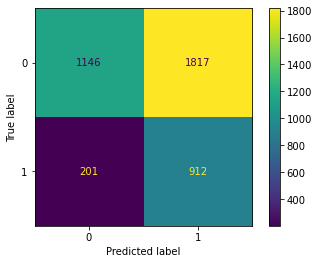

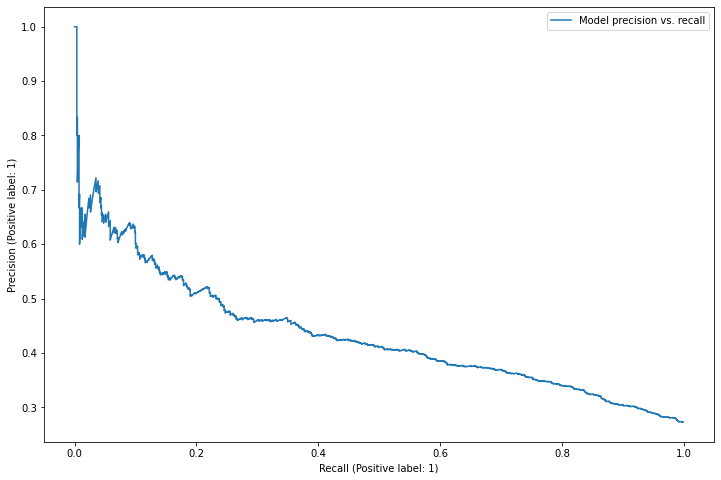

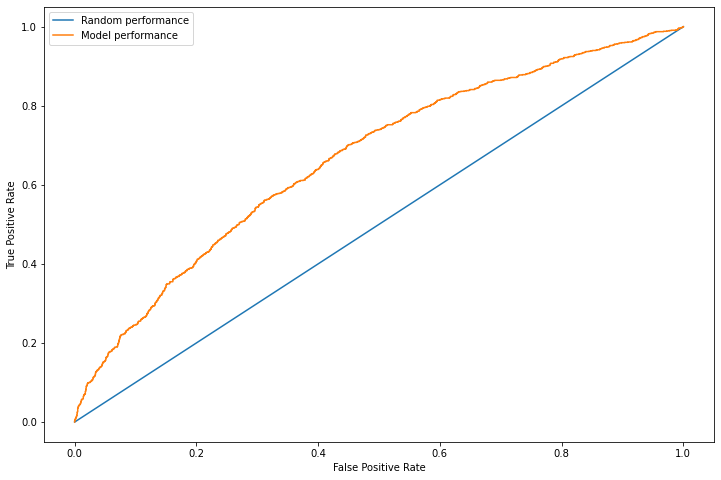

In [10]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [11]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
"""now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-07-Neural-Network-using-Adam' + date_time
print(result_file_basename)"""

"now = datetime.now()\ndate_time = now.strftime('%Y%m%d-%H%M')\nresult_file_basename = 'replication-07-Neural-Network-using-Adam' + date_time\nprint(result_file_basename)"

NameError: name 'result_file_basename' is not defined

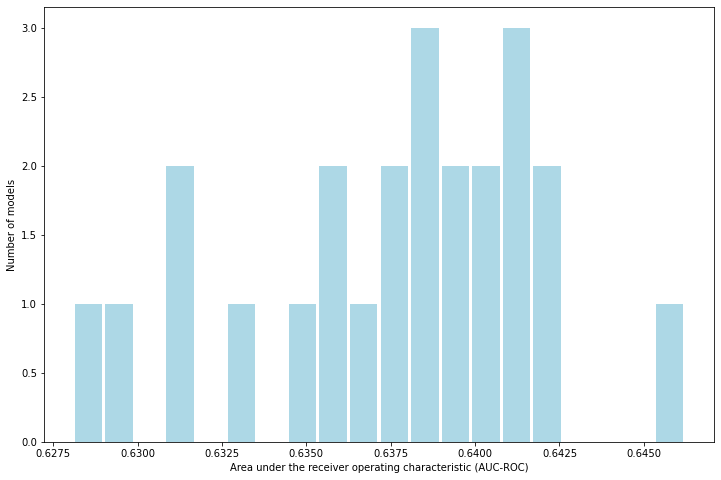

In [12]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
#plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Neural Network Replication using Adam: ' + result_file_basename);

"""result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)"""